# Анализ данных с временой структурой
# Проект 2

#### Участники:<br>
**Ванифатов Кирилл**<br>
**Молоков Андрей**

Задача:
Построить автоматизированный пайплайн для прогнозирования значений временного ряда

Требования:
- Выбор оптимизируемой метрики должен быть основан на потребностях бизнеса
- Модель может использовать внешние факторы (см подсказки)

- Модель должна иметь модуль отбора признаков
- Метод отбора должен быть болеее стабильным относительно альтернатив
- Сравнение должно быть проведено минимум с одним методом из каждой категории: встроенные, оберточные и фильтрационные
- При этом как минимум одна из альтернатив должа исследовать нелинейную зависимость

- Модель должна автоматически подбирать гиперпараметры, оптимизируя целевую метрику

- Для модели должна быть подобрана частота калибровки, если модель калибруется долго, и проверена ее достаточность

- Блоки должны быть подписаны и кратко описаны (чем руководствовались при реализации, как работает)
- Модель должна автоматически дообучаться
- Все модули должны работать без ручных корректировок
- Выбор периода для дообучения должен быть обоснован

- В модели должен быть модуль выявления разладки для подачи сигнала о возможной необходимости переключения на ручное управление процессом/внеплановое дообучение

Подсказки:
- Можно использовать факторы, сконструированные из таргета (лаги, средние и т.п.)
- Могут помочь макроэкономические факторы
- Могут помочь даты налоговых дней

Описание бизнес-процесса:
- Прогнозная величина позволяет установить сальдо поступлений и списаний за день
- На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи (доходность считать примерно ключ+0.5%)
- В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключу-0.9%
- В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключ+1%

In [ ]:
# !pip3 install statsmodels
# !pip3 install seaborn
# !pip3 install scikit-learn
# !pip3 install arch
# !pip install pandas
# !pip install np
# !pip install -U scikit-learn scipy
# !pip install matplotlib
# !pip install ruptures 


  Using cached ruptures-1.1.9.tar.gz (308 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build ruptures


  error: subprocess-exited-with-error
  
  × Building wheel for ruptures (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [101 lines of output]
      C:\Users\User\AppData\Local\Temp\pip-build-env-4st97oqr\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: BSD License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ********************************************************************************
      
      !!
        self._finalize_license_expression()
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-313

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings 

warnings.filterwarnings('ignore')

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from statsmodels.tsa.stattools import adfuller, kpss

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

import scipy.stats as scs
import statsmodels.api as sm

np.random.seed(42)
# import statsmodels as smt

In [ ]:
data_origin = pd.read_csv('Project_Data.csv')
data_origin.shape

(1543, 4)

In [ ]:
data_origin['Date'] = pd.to_datetime(data_origin['Date']).dt.date
data_origin = data_origin.set_index('Date')
data_origin = data_origin.asfreq('D')
data_origin.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721


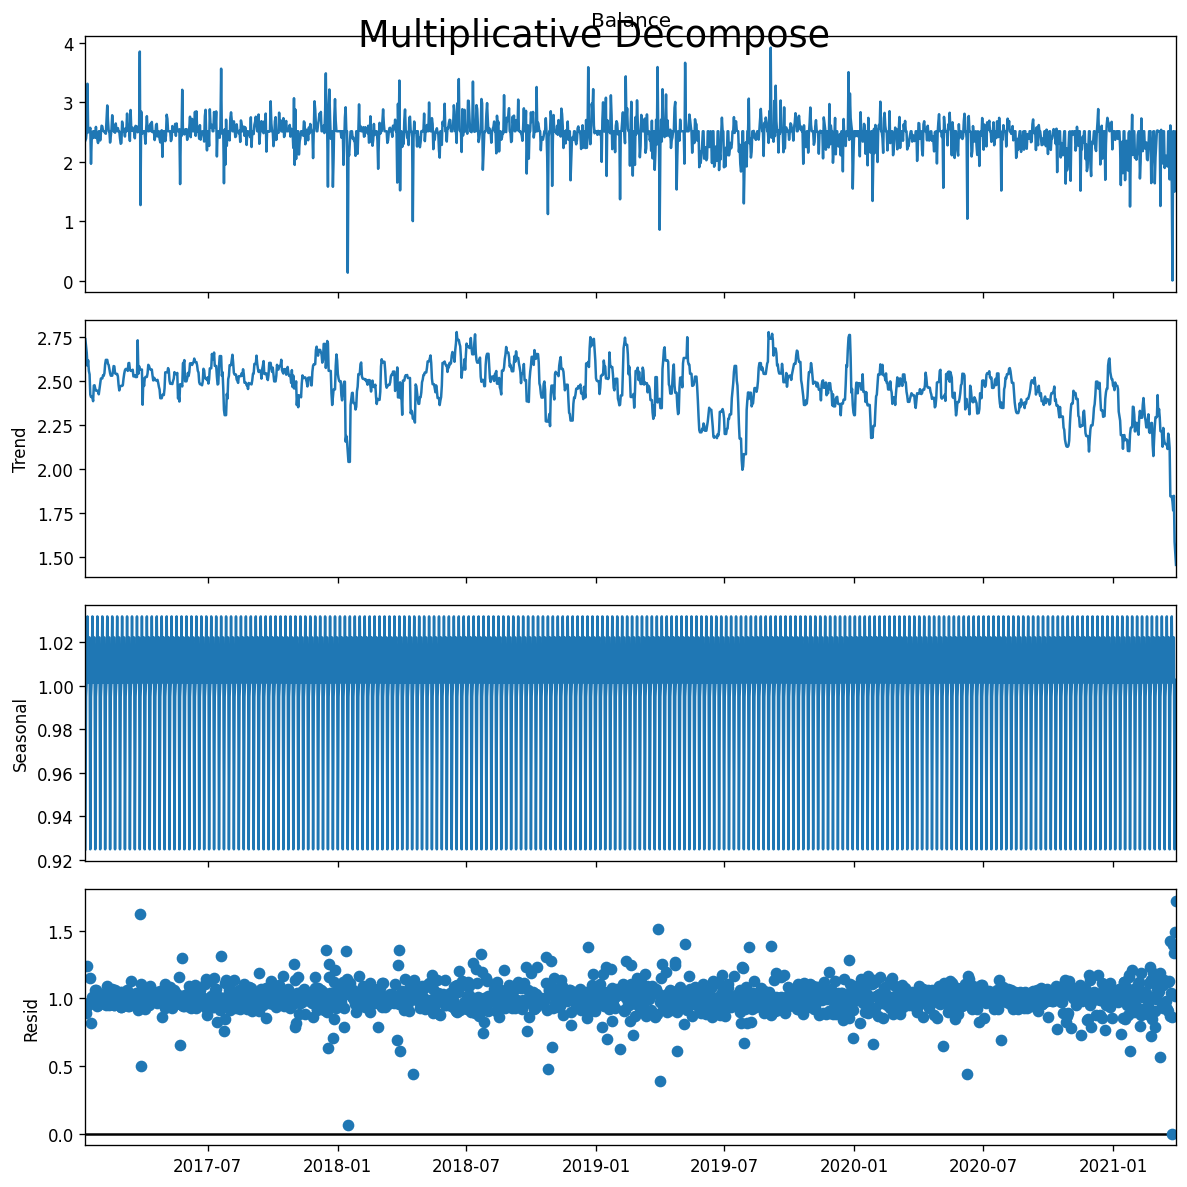

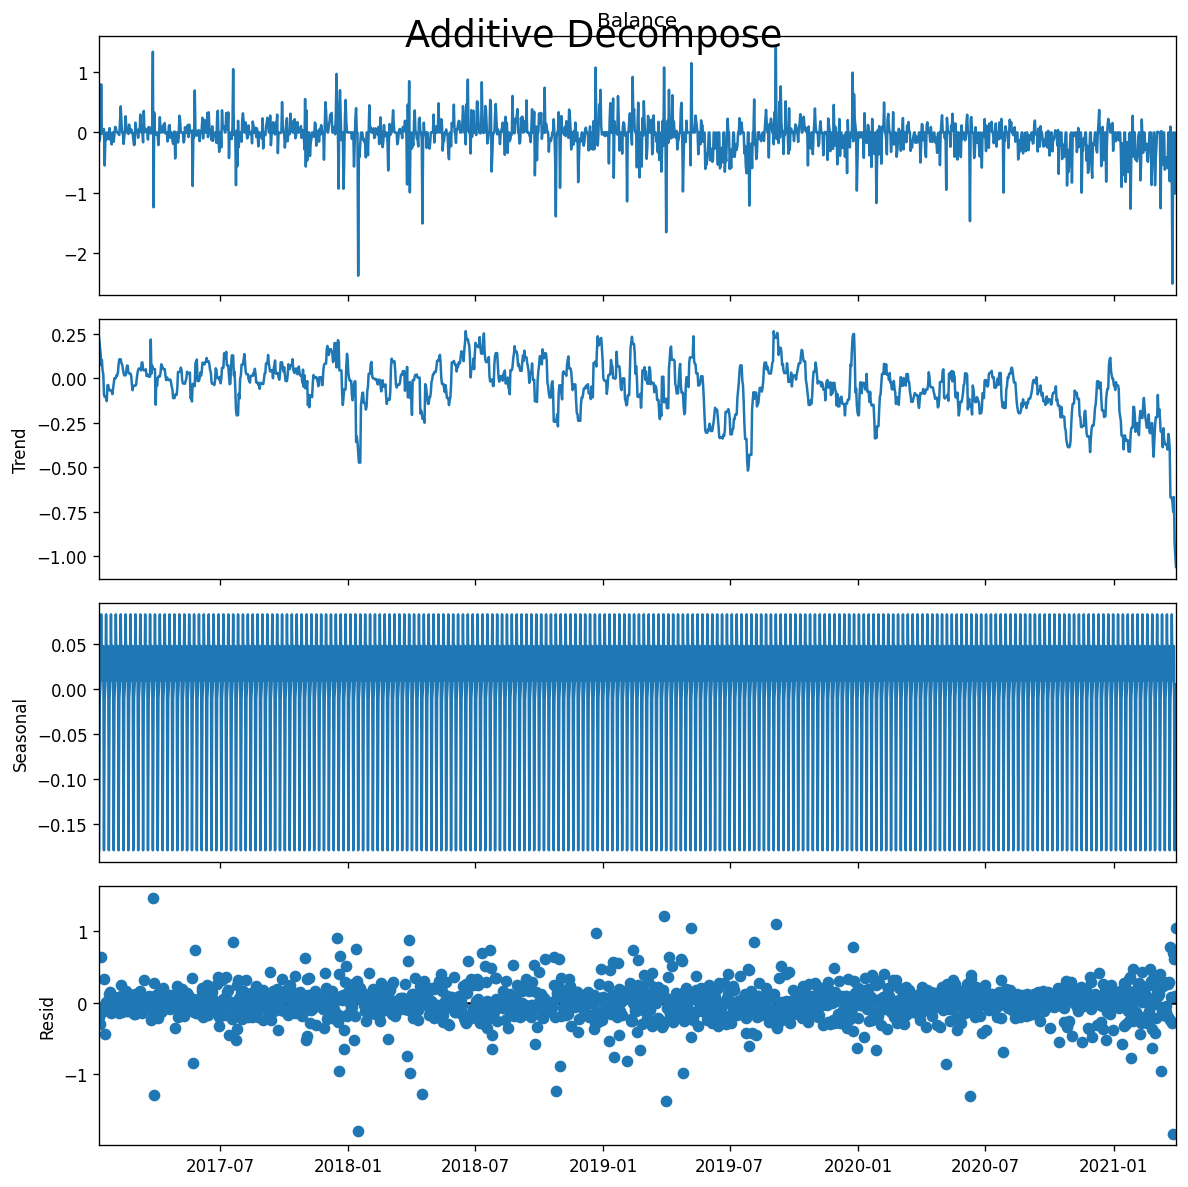

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data_origin['Balance'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2017-01-09,0.924902,2.738203,0.931459,2.358984
2017-01-10,0.994942,2.699560,0.889576,2.389315
2017-01-11,1.002635,2.660917,0.945548,2.522654
2017-01-12,1.031763,2.587311,1.241914,3.315278
2017-01-13,1.001498,2.617868,0.951704,2.495166


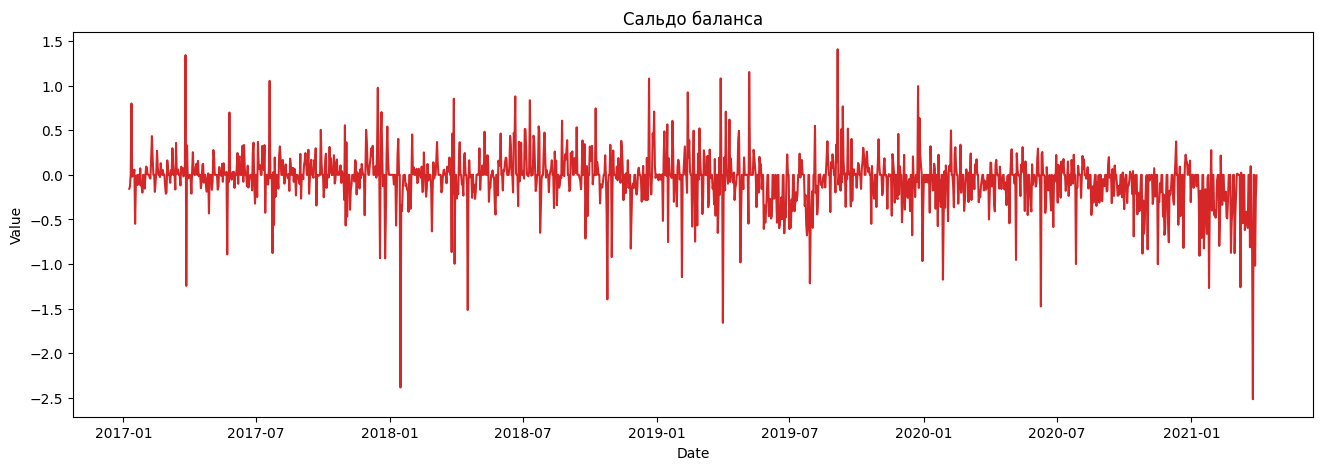

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data_origin, x=data_origin.index, y=data_origin.Balance, title='Сальдо баланса')    


#### ACF

Количественной характеристикой сходства между значениями ряда в соседних точках является автокорреляционная функция (или просто автокорреляция), которая задаётся следующим соотношением:
$$r_τ = \frac{E((y_t − Ey)(y_{t-τ} − Ey))}{Dy}$$

**Автокорреляция** — это уже встречавшаяся ранее корреляция Пирсона между исходным рядом и его версией,
сдвинутой на несколько отсчётов. Количество отсчётов, на которое сдвинут ряд, называется лагом автокорреляции (τ ).

Вычислить автокорреляцию по выборке можно, заменив в формуле математическое ожидание на выборочное среднее, а дисперсию — на выборочную дисперсию.

Анализировать величину автокорреляции при разных значениях лагов удобно с помощью графика, который называется коррелограммой. По оси ординат на нём откладывается автокорреляция, а по оси абсцисс —
размер лага τ.

Как и для обычной корреляции Пирсона,
значимость вычисляется с помощью критерия Стьюдента. Альтернатива чаще всего двусторонняя, потому что при анализе временных рядов крайне редко имеется гипотеза о том, какой должна быть
корреляция, положительной или отрицательной.


временной ряд: $y^T = y_1, . . . , y_T$

нулевая гипотеза: $H_0 : r_τ = 0$

альтернатива: $H_1 : r_τ \neq 0$

статистика: $T(y^T) =\frac{ r_τ \sqrt{T - τ−2}}{\sqrt{1−r^2_τ}};$

нулевое распределение: $T(y^T) ∼ St(T − τ − 2).$





#### PACF

Частичная автокорреляция - это сводка взаимосвязи между наблюдением во временном ряду с наблюдениями на предыдущих временных этапах с удалением взаимосвязей между промежуточными наблюдениями.

**Частичная автокорреляция** при лаге k - это корреляция, возникающая после устранения влияния любых корреляций, связанных с членами с более короткими лагами.


Поскольку автоковариация стационарного  ряда зависит только от сдвига, то и автокорреляция – это функция только сдвига k,
$$ρ(k) = \frac{cov(y_t, y_{t−k} )}{σ^2_y} = \frac{γ(k)}{γ(0)}, k ≥ 0.$$


 По сути, вместо того, чтобы находить корреляции настоящего с лагами, такими как ACF, он находит корреляцию остатков (которая сохраняется после устранения эффектов, которые уже были объяснены более ранним лагом (ами)) со следующим значением лага, следовательно, «частичным», а не «полным». 
 


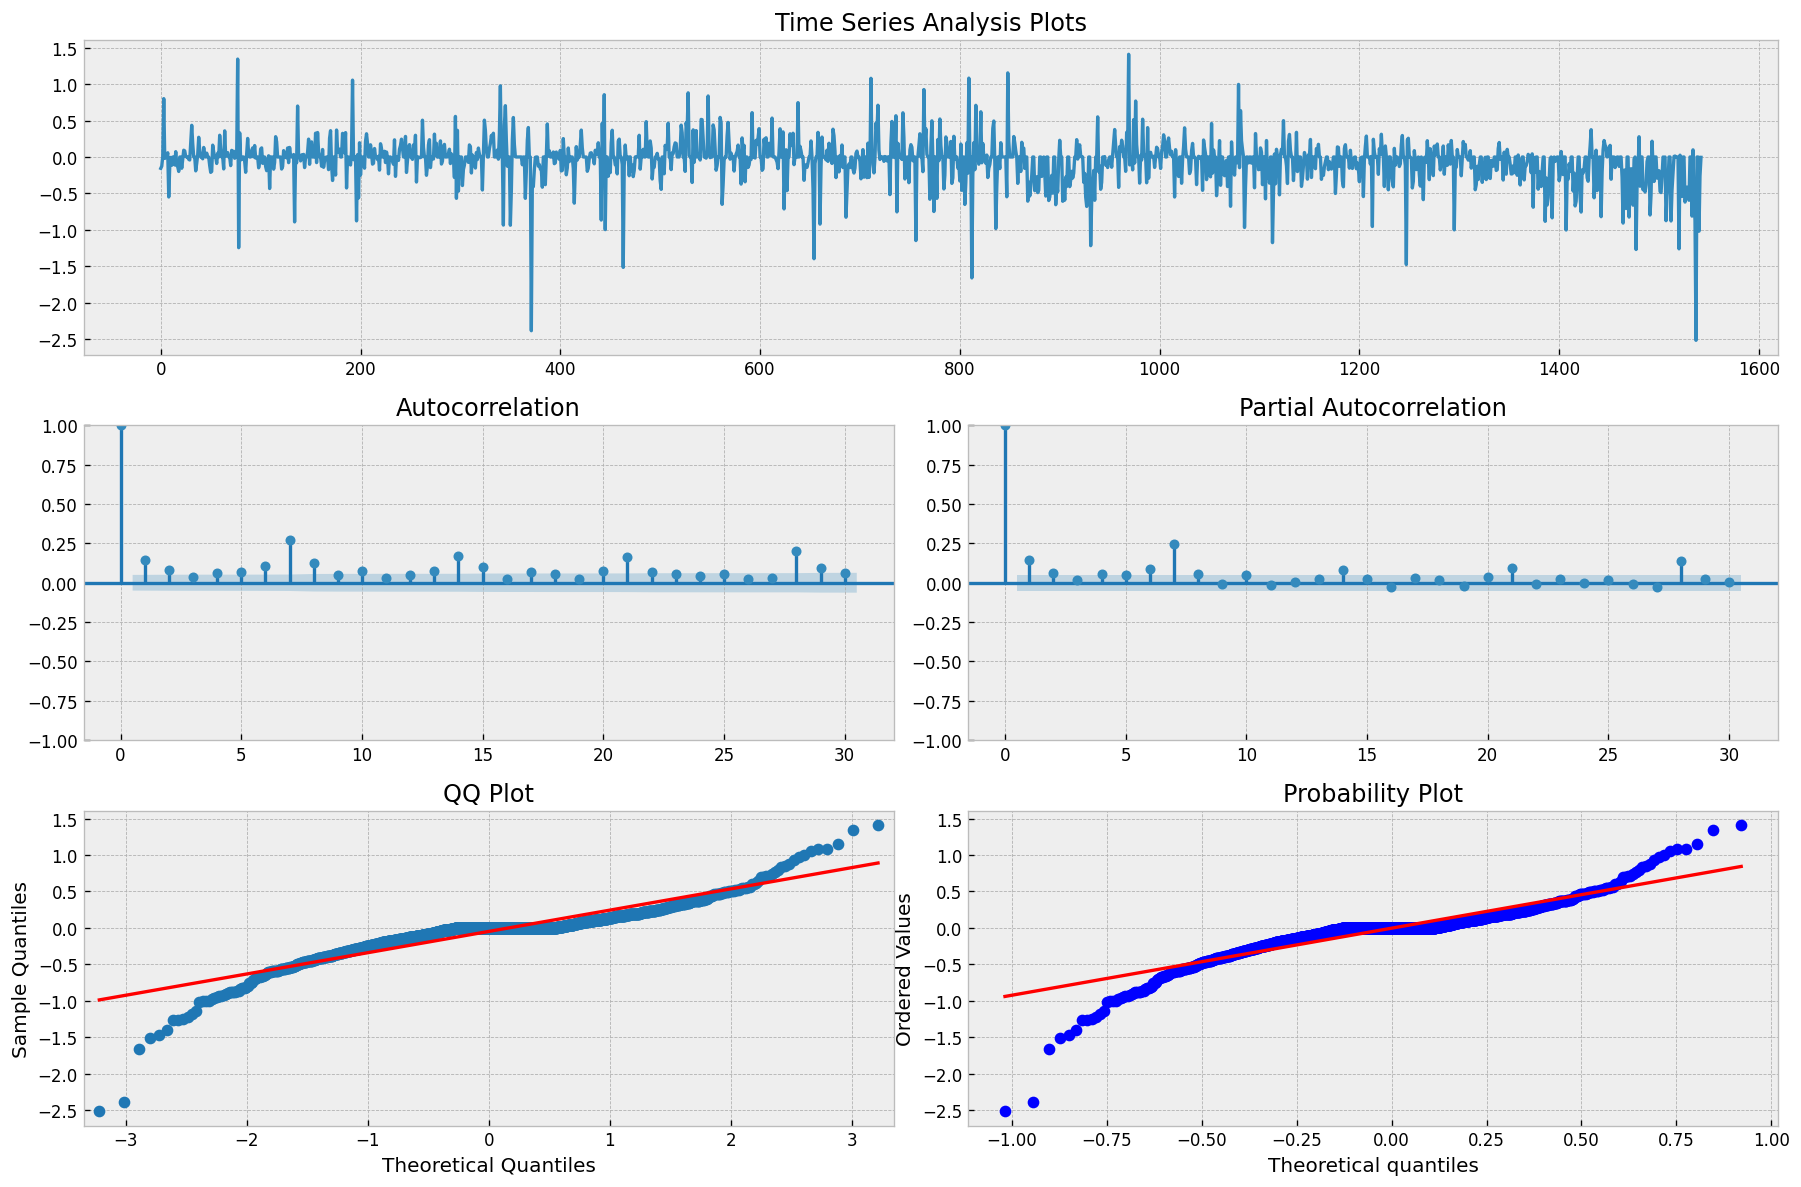

In [ ]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

tsplot(data_origin['Balance'], lags=30)

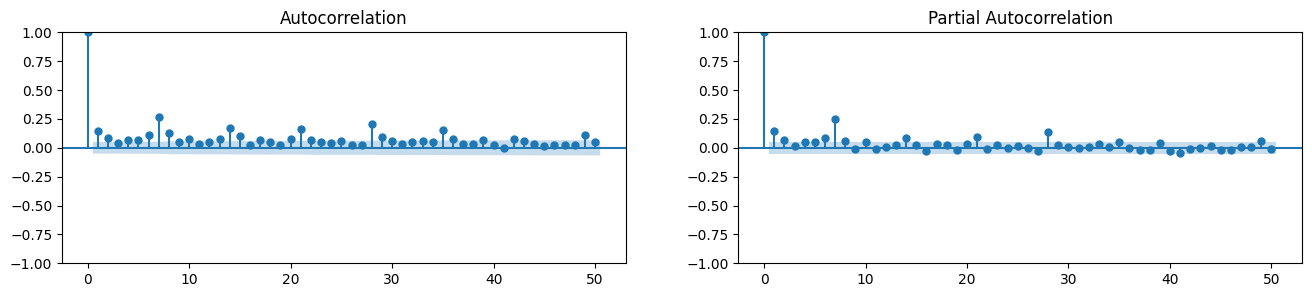

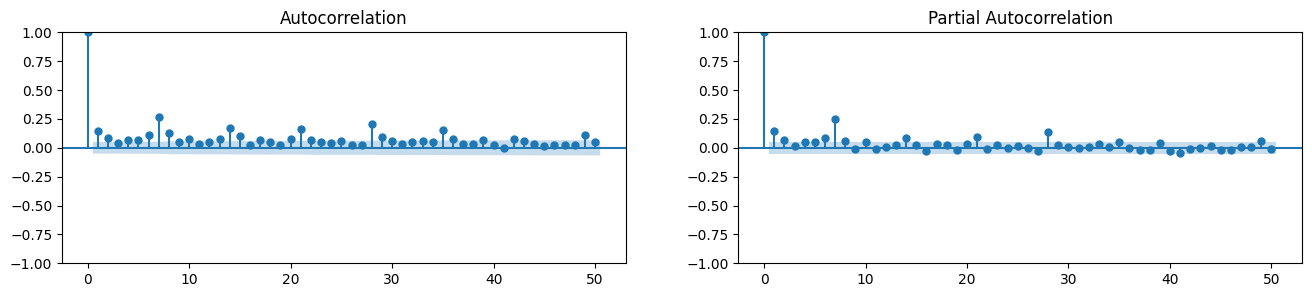

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_origin['Balance'], lags=50, ax=axes[0])
plot_pacf(data_origin['Balance'], lags=50, ax=axes[1])

#### Авторегрессия


Можно перейти к следующей идее: делать регрессию для ряда не на какие-то внешние признаки, зависящие
от времени, а на его собственные значения в прошлом:

$$y_t = α + φ_1 y_{t−1} + φ_2 y_{t−2} + · · · + φ_p y_{t−p} + ε_t.$$

В этом регрессионном уравнении $y_t$ — это отклик, $y_{t−1}, y_{t−2},\dots , y_{t−p}$ — признаки, $α, φ_1, φ_2, . . . , φ_p$ — параметры
модели, которые необходимо оценить, $ε_t$ — шумовая компонента, описывает отклонения значений ряда от
данного уравнения.


Такая модель называется моделью авторегрессии порядка p (AR(p)). В этой модели $y_t$ представляет собой
линейную комбинацию p предыдущих значений ряда и шумовой компоненты.



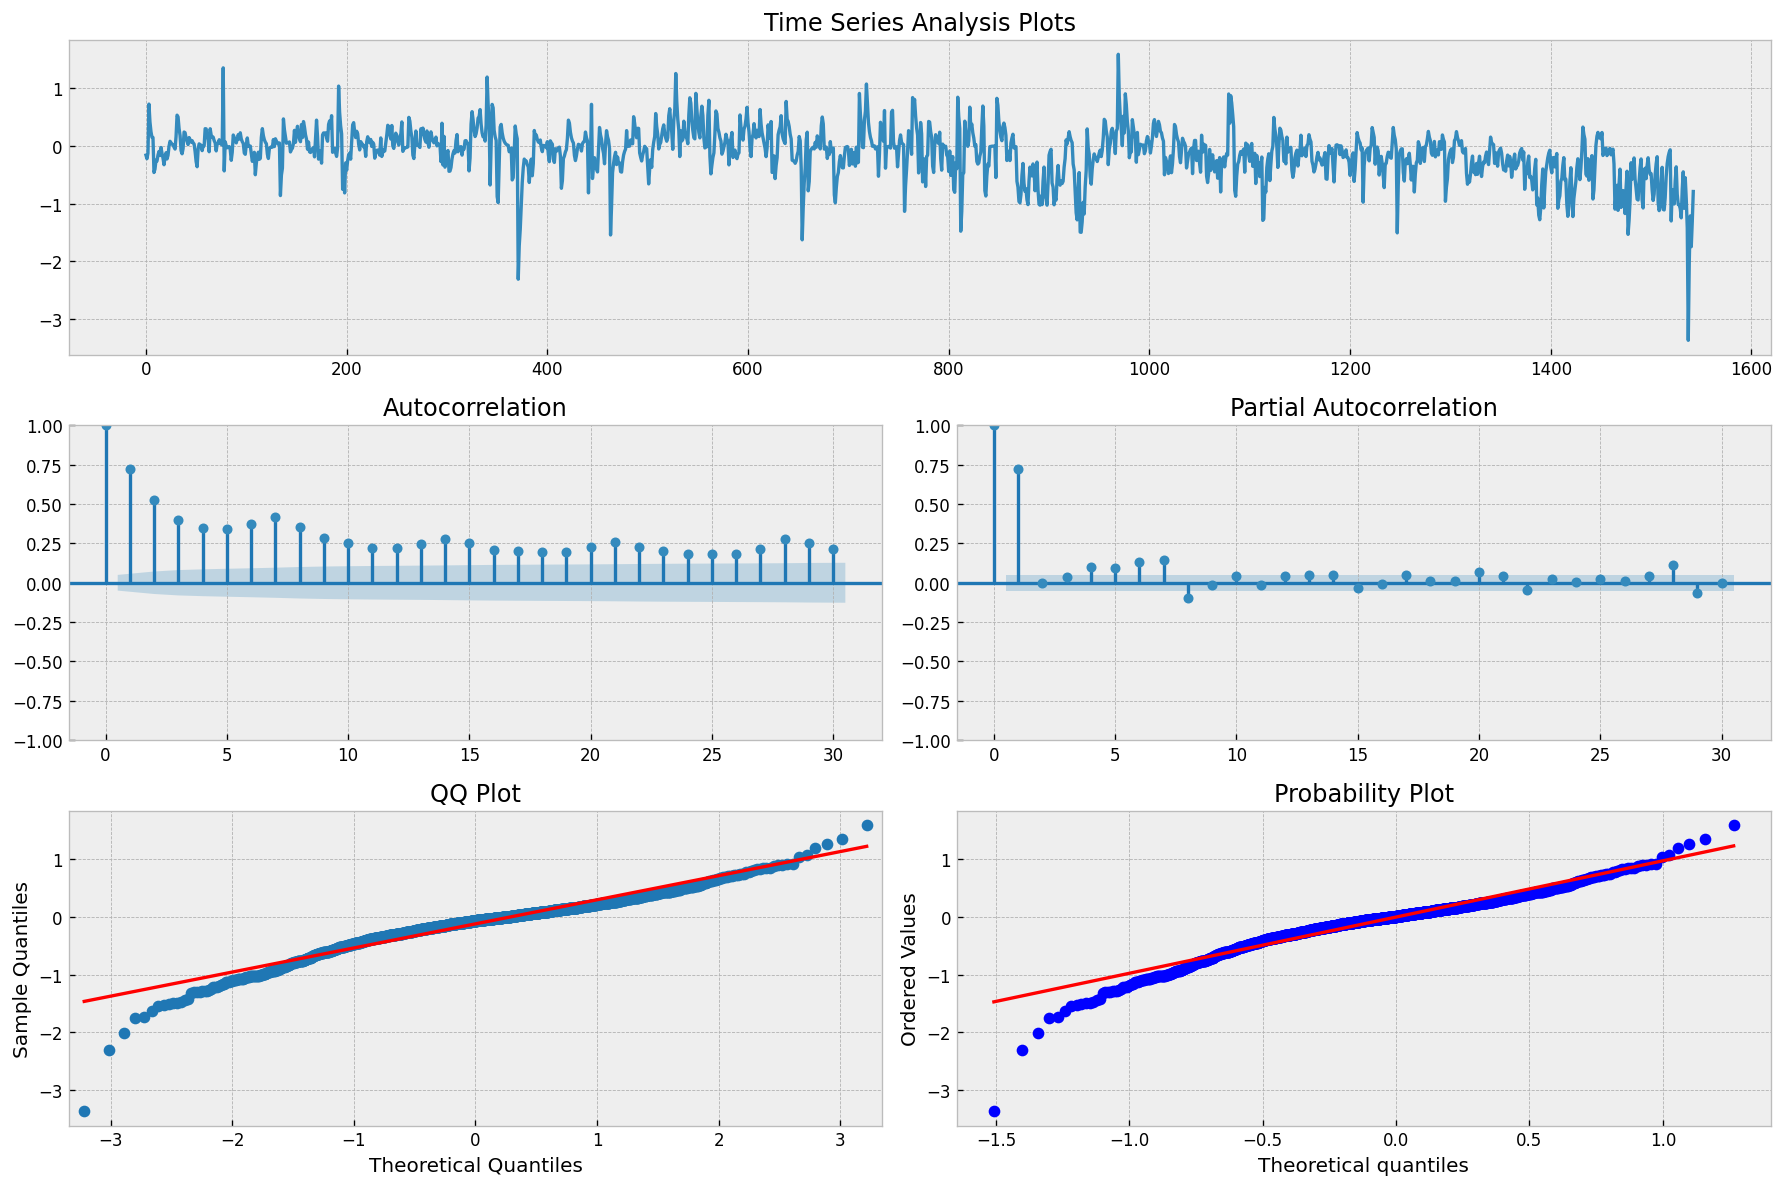

In [ ]:
n_samples = len(data_origin['Balance'])
a = 0.6
x = w = data_origin['Balance'].to_numpy() 
lags = 30
for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=lags)

#### Проверка стационарности:

- Пристальное вглядывание в график временного ряда
- Разбиение на части и подсчет статистик
- Тесты на единичные корни
- Dickey Fuller test (ADH Test)
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
- Philips Perron test (PP Test)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def stationarity_check(data: pd.Series) -> None:
    """
    Проверяет стационарность временного ряда с помощью тестов ADF, KPSS и Phillips-Perron.
    Выводит статистику, p-значения и заключение о стационарности после каждого теста.
    Также анализирует среднее и дисперсию двух половин ряда.

    Parameters:
    -----------
    data : pd.Series
        Входные данные (временной ряд). Должен быть типа pandas.Series.
    """
    if not isinstance(data, pd.Series):
        raise ValueError("Входные данные должны быть типа pandas.Series")
    
    df = data.sort_index().dropna()
    
    if len(df) < 2:
        raise ValueError("Недостаточно данных для анализа стационарности")
    
    midpoint = len(df) // 2
    df_first_half = df.iloc[:midpoint]
    df_second_half = df.iloc[midpoint:]

    mean_first = df_first_half.mean()
    var_first = df_first_half.var()
    mean_second = df_second_half.mean()
    var_second = df_second_half.var()

    print("\n=== Анализ среднего и дисперсии ===")
    print(f"Первая половина - Среднее: {mean_first:.4f}, Дисперсия: {var_first:.4f}")
    print(f"Вторая половина - Среднее: {mean_second:.4f}, Дисперсия: {var_second:.4f}")
    
    if abs(mean_first - mean_second) > 0.1 * abs(mean_first) or abs(var_first - var_second) > 0.1 * abs(var_first):
        print("Различия в среднем или дисперсии указывают на возможную нестационарность.")
    else:
        print("Среднее и дисперсия стабильны, что может указывать на стационарность.")

    print("\n=== Тест Дики-Фуллера (ADF) ===")
    adf_result = adfuller(df)
    print(f"Статистика теста: {adf_result[0]:.4f}")
    print(f"p-значение: {adf_result[1]:.4f}")
    print(f"Критические значения: {adf_result[4]}")
    adf_stationary = adf_result[1] < 0.05 and adf_result[0] < adf_result[4]['5%']
    print(f"Заключение: Ряд {'стационарен' if adf_stationary else 'нестационарен'} по тесту ADF.")

    print("\n=== Тест KPSS (трендовая стационарность) ===")
    kpss_result = kpss(df, regression='ct')
    print(f"Статистика теста: {kpss_result[0]:.4f}")
    print(f"p-значение: {kpss_result[1]:.4f}")
    print(f"Критические значения: {kpss_result[3]}")
    kpss_stationary = kpss_result[1] >= 0.05
    print(f"Заключение: Ряд {'стационарен' if kpss_stationary else 'нестационарен'} по тесту KPSS.")

    print("\n=== Тест Филлипса-Перрона (PP) ===")
    pp = PhillipsPerron(df)
    print(pp.summary())
    pp_stationary = pp.pvalue < 0.05
    print(f"Заключение: Ряд {'стационарен' if pp_stationary else 'нестационарен'} по тесту PP.")

    print("\n=== Итоговый вывод ===")
    if adf_stationary and pp_stationary and not kpss_stationary:
        print("Расхождение тестов: Ряд, вероятно, стационарен после удаления тренда.")
    elif adf_stationary and pp_stationary and kpss_stationary:
        print("Ряд стационарен по всем тестам.")
    elif not adf_stationary and not pp_stationary and not kpss_stationary:
        print("Ряд нестационарен по всем тестам.")
    else:
        print("Тесты дают противоречивые результаты. Рекомендуется дополнительный анализ.")

In [ ]:
stationarity_check(data_origin['Balance'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0089, Дисперсия: 0.0725
Вторая половина - Среднее: -0.1065, Дисперсия: 0.0914
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -4.1141
p-значение: 0.0009
Критические значения: {'1%': np.float64(-3.4346537865963596), '5%': np.float64(-2.8634408535813285), '10%': np.float64(-2.5677819879092625)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.3539
p-значение: 0.0100
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд нестационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -39.428
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothe

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_88511/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df, regression='ct')


**Анализ статистик (среднее и дисперсия)**
- Среднее значение изменилось с положительного в первой половине на отрицательное во второй, что указывает на возможное изменение тренда или уровня ряда.
- Дисперсия увеличилась, что говорит о росте волатильности во второй половине.
- Эти различия свидетельствуют о нестационарности ряда, так как стационарный ряд должен иметь постоянные среднее и дисперсию во времени.

**Тест Дики-Фуллера (ADF)**
- Статистика теста меньше критических значений.
- p-значение** < 0.05.
Ряд **стационарен** согласно тесту ADF.

**Тест KPSS (трендовая стационарность)**
- Статистика теста больше критических значений.
- p-значение < 0.05.
Ряд **нестационарен** по тесту KPSS.

**Тест Филлипса-Перрона (PP)**
- Статистика теста значительно меньше критических значений.
- p-значение < 0.05.
- Ряд **стационарен** согласно тесту PP.

Расхождение тестов свидетельствует о том, что ряд стационарен после удаления тренда.

In [ ]:
stationarity_check(data_origin['Income'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.9793, Дисперсия: 0.5624
Вторая половина - Среднее: 1.1904, Дисперсия: 0.8227
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -5.4000
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.1176
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -26.825
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: 

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_88511/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df, regression='ct')


In [ ]:
stationarity_check(data_origin['Outcome'])


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.9704, Дисперсия: 0.5685
Вторая половина - Среднее: 1.2968, Дисперсия: 1.0058
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -4.0097
p-значение: 0.0014
Критические значения: {'1%': np.float64(-3.434656620970318), '5%': np.float64(-2.863442104538126), '10%': np.float64(-2.5677826540508275)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0806
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -29.546
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: 

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_88511/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df, regression='ct')


**Стабилизация дисперсии**

В случае, если во временном ряде монотонно по времени изменяется дисперсия, применяется специальное преобразование, стабилизирующее дисперсию.

 Очень часто в качестве такого преобразования выступает логарифмирование. 
 
Логарифмирование принадлежит к семейству преобразований Бокса-Кокса.

$$y_t' =\begin{cases}
\ln y_t, \lambda=0 \\
(y_t^\lambda - 1)/\lambda, \lambda \neq 0
\end{cases} $$


Это параметрическое семейство функций, в котором параметр λ определяет, как именно будет преобразован
ряд: 

λ = 0 — это логарифмирование, 

λ = 1 — тождественное преобразование ряда, 

а при других значениях
λ — степенное преобразование.

 Значение параметра можно подбирать так, чтобы дисперсия была как можно
более стабильной во времени.


**Как избавиться от тренда?**

- Воспользоваться линейной регрессией на шаг временного ряда ( используя также степенные компоненты)
- Вычесть среднее
- Baxter-King filter(statsmodels.tsa.filters.bkfilter) или Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) чтобы убрать среднее или циклическую компоненту

Text(0.5, 1.0, 'Сальдо балансов')

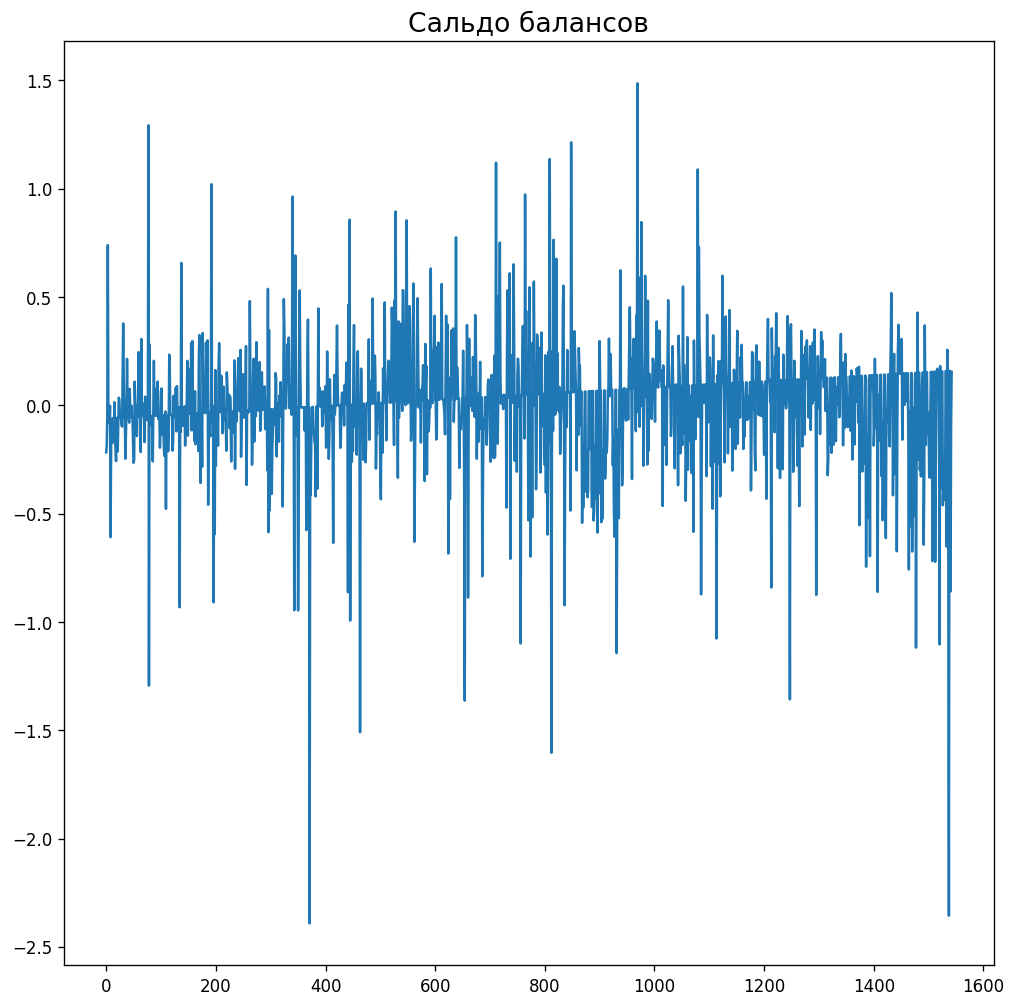

In [ ]:
from scipy import signal

detrended = signal.detrend(data_origin['Balance'])
plt.plot(detrended)
plt.title('Сальдо балансов', fontsize=16)

Визуально прослеживается положительный тренд

Text(0.5, 1.0, 'Сальдо балансов')

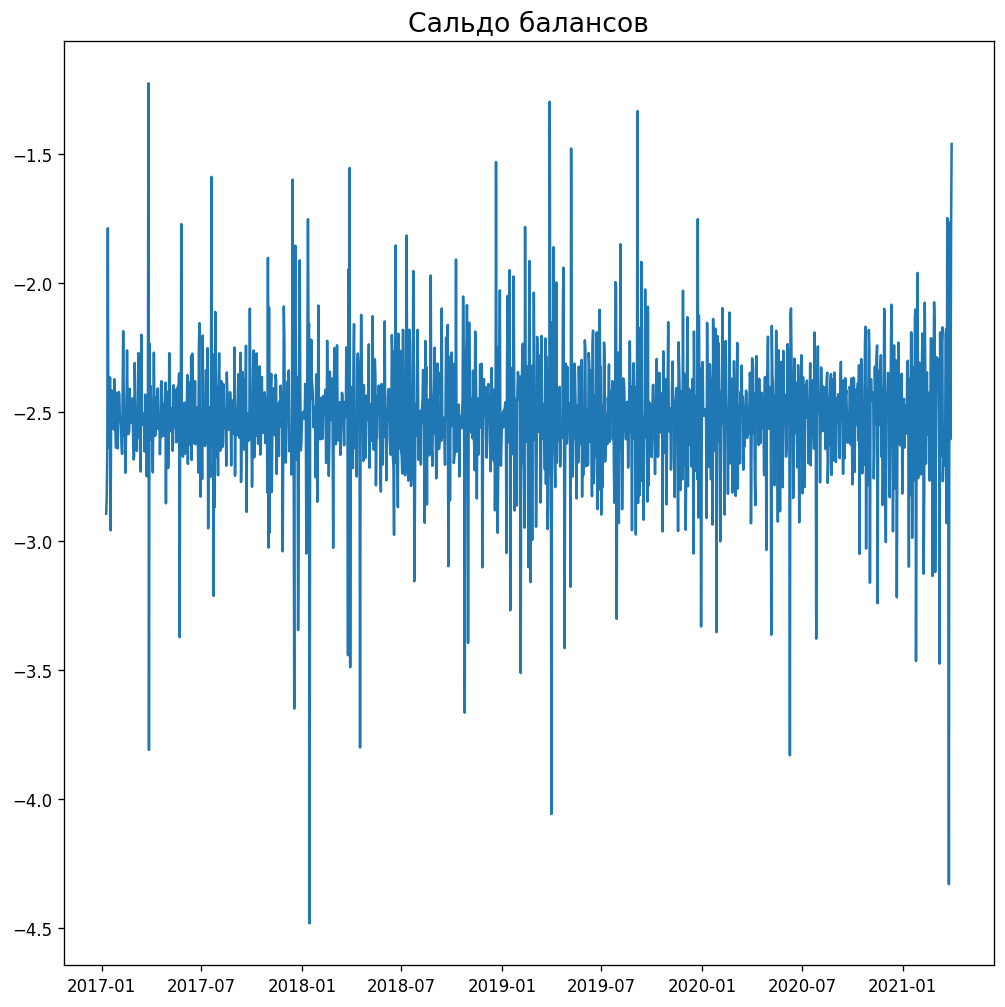

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')
detrended = data_origin['Balance'] - result_mul.trend
plt.plot(detrended)
plt.title('Сальдо балансов', fontsize=16)

In [ ]:
from sklearn.linear_model import LinearRegression

def detrend_linear_regression(data: pd.Series, degree: int = 2) -> pd.Series:
    """
    Удаляет тренд из временного ряда с помощью линейной регрессии, используя шаг времени
    и его степенные компоненты
    """
    if not isinstance(data, pd.Series):
        raise ValueError("Входные данные должны быть типа pandas.Series")
    df = data.dropna().copy()
    if len(df) < 2:
        raise ValueError("Недостаточно данных для анализа")

    t = np.arange(len(df)).reshape(-1, 1)
    
    X = np.hstack([t**i for i in range(1, degree + 1)])
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        model = LinearRegression()
        model.fit(X, df.values)
    
    trend = model.predict(X)
    detrended = df - trend
    
    return pd.Series(detrended, index=df.index, name=df.name)

In [ ]:
stationarity_check(detrend_linear_regression(data_origin['Balance']))


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0025, Дисперсия: 0.0726
Вторая половина - Среднее: -0.0025, Дисперсия: 0.0877
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -6.1247
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.4346537865963596), '5%': np.float64(-2.8634408535813285), '10%': np.float64(-2.5677819879092625)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.1280
p-значение: 0.0834
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -37.617
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesi

In [ ]:
data_linreg = data_origin.copy()
data_linreg['Balance'] = detrend_linear_regression(data_origin['Balance'])
data_linreg.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.143845
2017-01-10,1.068610,1.194182,-0.113657
2017-01-11,0.944429,0.936663,0.019539
2017-01-12,1.672202,0.875379,0.812021
2017-01-13,0.955924,0.975645,-0.008232


In [ ]:
def detrend_mean_subtraction(data: pd.Series, window: int = None) -> pd.Series:
    """
    Удаляет тренд из временного ряда путем вычитания среднего.
    Если указан window, используется скользящее среднее, иначе — общее среднее.
    """
    if not isinstance(data, pd.Series):
        raise ValueError("Входные данные должны быть типа pandas.Series")
    df = data.dropna().copy()
    if len(df) < 2:
        raise ValueError("Недостаточно данных для анализа")

    if window is None:
        trend = df.mean()
        detrended = df - trend
    else:
        if window < 1 or window > len(df):
            raise ValueError("Недопустимый размер окна")
        trend = df.rolling(window=window, center=True).mean()
        detrended = df - trend
    
    return pd.Series(detrended, index=df.index, name=df.name).dropna()

In [ ]:
stationarity_check(detrend_mean_subtraction(data_origin['Balance'], window=7))


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: -0.0001, Дисперсия: 0.0633
Вторая половина - Среднее: 0.0008, Дисперсия: 0.0700
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -17.0556
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.4346765666049732), '5%': np.float64(-2.8634509075517536), '10%': np.float64(-2.5677873417107437)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0293
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -98.610
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothes

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_88511/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df, regression='ct')


In [ ]:
data_mean_sub = data_origin.copy()
data_mean_sub['Balance'] = detrend_mean_subtraction(data_origin['Balance'], window=7)
data_mean_sub.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,NaN
2017-01-10,1.068610,1.194182,NaN
2017-01-11,0.944429,0.936663,NaN
2017-01-12,1.672202,0.875379,0.727968
2017-01-13,0.955924,0.975645,-0.122701


В этом случае мы теряем 3 первых значения таргета

**Взятие разности** <br>
Важный трюк, который позволяет сделать ряд стационарным, — это дифференцирование, переход к попарным разностям соседних значений:
$$y' = y_t − y_{t−1}$$
Для нестационарного ряда часто оказывается, что получаемый после дифференцирования ряд является
стационарным. <br>
Дифференцирование можно применять неоднократно: от ряда первых
разностей, продифференцировав его, можно прийти к ряду вторых разностей, и т. д. <br>
Также может применяться сезонное дифференцирование ряда, переход к попарным разностям значений
в соседних сезонах. Если длина периода сезона составляет s, то новый ряд задаётся разностями
$$y'_t = y_t − y_{t−s}.$$
Сезонное и обычное дифференцирование могут применяться к ряду в любом порядке. Однако если у ряда
есть ярко выраженный сезонный профиль, то рекомендуется начинать с сезонного дифференцирования, уже
после такого преобразования может оказаться, что ряд стационарен.


In [ ]:
stationarity_check(data_origin['Balance'].diff().dropna())


=== Анализ среднего и дисперсии ===
Первая половина - Среднее: 0.0004, Дисперсия: 0.1389
Вторая половина - Среднее: -0.0002, Дисперсия: 0.1530
Различия в среднем или дисперсии указывают на возможную нестационарность.

=== Тест Дики-Фуллера (ADF) ===
Статистика теста: -14.7654
p-значение: 0.0000
Критические значения: {'1%': np.float64(-3.4346537865963596), '5%': np.float64(-2.8634408535813285), '10%': np.float64(-2.5677819879092625)}
Заключение: Ряд стационарен по тесту ADF.

=== Тест KPSS (трендовая стационарность) ===
Статистика теста: 0.0449
p-значение: 0.1000
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Заключение: Ряд стационарен по тесту KPSS.

=== Тест Филлипса-Перрона (PP) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic               -178.792
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothes

/var/folders/85/s3wbgppx3bd4pz8hvr_pjl7m0000gn/T/ipykernel_88511/1919798344.py:50: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df, regression='ct')


In [ ]:
data_diff = data_origin.copy()
data_diff['Balance'] = data_origin['Balance'].diff().dropna()
data_diff.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,NaN
2017-01-10,1.068610,1.194182,0.030332
2017-01-11,0.944429,0.936663,0.133339
2017-01-12,1.672202,0.875379,0.792624
2017-01-13,0.955924,0.975645,-0.820112


В этом случае мы теряем один день записи из за пропущенного значения таргета в ходе дифференцирования

**Как учесть сезонность?**
- Скользящее среднее с сезонным окном. 
- Сезонные разности
- Разбить ряд по временным индексами

[]

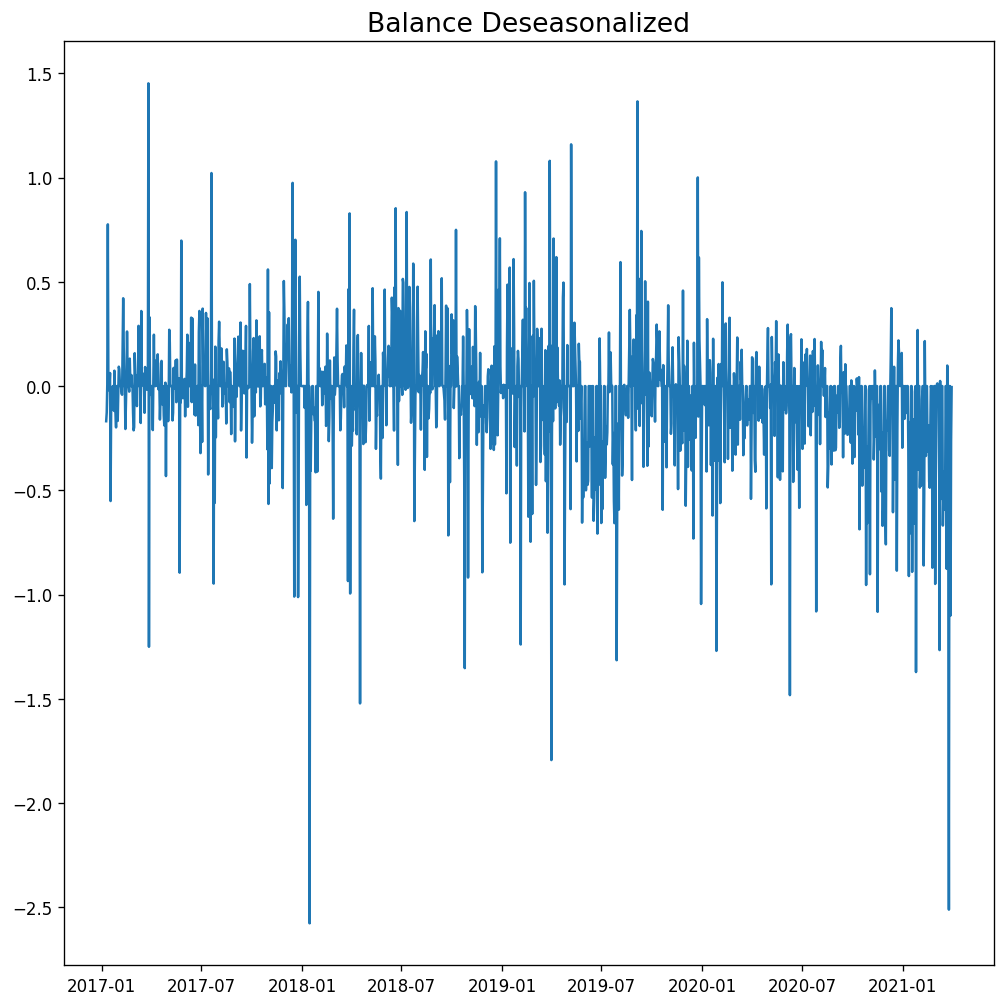

In [ ]:

result_mul = seasonal_decompose(data_origin['Balance'] + abs(data_origin['Balance'].min())+0.000001, model='multiplicative', extrapolate_trend='freq')
deseasonalized = data_origin['Balance'] / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Balance Deseasonalized', fontsize=16)
plt.plot()

**Тест на сезонность**

- По дням (месяца)
- По неделям
- По месяцам
- По годам

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

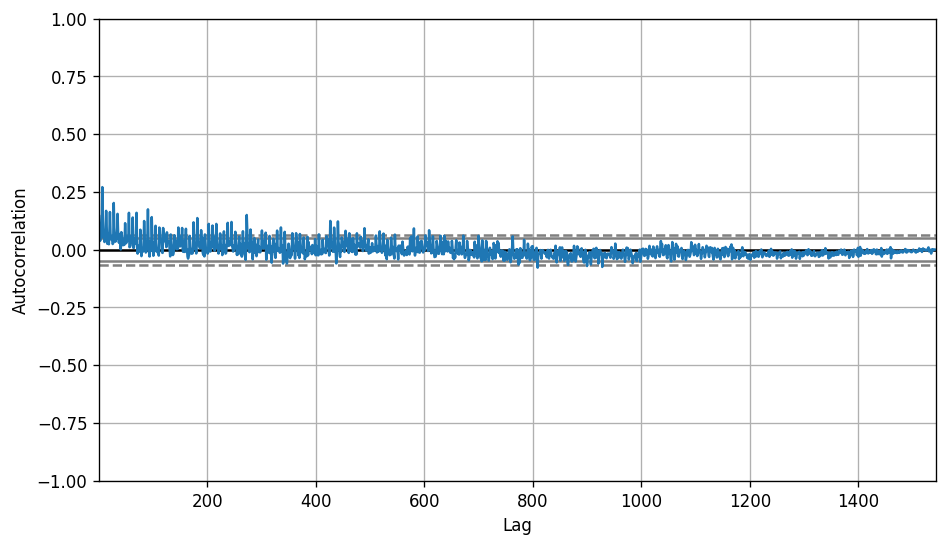

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(data_origin['Balance'])

Явной сезонности не наблюдается

# Итог первого блока. сделали таргет стационарным с помощью линрега. дальше работает с этими данными

In [ ]:
data_linreg

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.143845
2017-01-10,1.068610,1.194182,-0.113657
2017-01-11,0.944429,0.936663,0.019539
2017-01-12,1.672202,0.875379,0.812021
2017-01-13,0.955924,0.975645,-0.008232
...,...,...,...
2021-03-27,0.000000,0.000000,0.230997
2021-03-28,0.000000,0.000000,0.231425
2021-03-29,2.356883,3.370738,-0.785826


# Добавление макроэкономических факторов

- Ключевая ставка ЦБ
- Индекс MosPrime
- Индекс moex
- Даты налоговых дней

In [ ]:
from datetime import datetime

start_date = datetime.strptime('2017-01-09', '%Y-%m-%d').date()
end_date = datetime.strptime('2021-03-31', '%Y-%m-%d').date()

In [ ]:
# data_origin = data_origin.reset_index()
# data_origin['Date'] = pd.to_datetime(data_origin['Date'], errors='coerce').dt.date
# data_origin = data_origin.drop(columns=['index', 'level_0'], axis=1, errors='ignore')
# data_origin = data_origin.reset_index(drop=True)
# data_origin

data_linreg = data_linreg.reset_index()
data_linreg['Date'] = pd.to_datetime(data_linreg['Date'], errors='coerce').dt.date
data_linreg = data_linreg.drop(columns=['index', 'level_0'], axis=1, errors='ignore')
data_linreg = data_linreg.reset_index(drop=True)
data_linreg

,Date,Income,Outcome,Balance
0,2017-01-09,1.343028,1.487865,-0.143845
1,2017-01-10,1.068610,1.194182,-0.113657
2,2017-01-11,0.944429,0.936663,0.019539
3,2017-01-12,1.672202,0.875379,0.812021
4,2017-01-13,0.955924,0.975645,-0.008232
...,...,...,...,...
1538,2021-03-27,0.000000,0.000000,0.230997
1539,2021-03-28,0.000000,0.000000,0.231425
1540,2021-03-29,2.356883,3.370738,-0.785826
1541,2021-03-30,2.317382,2.567554,-0.027404


In [ ]:
mosprime = pd.read_csv('mosprime.csv', encoding='cp1251', skiprows=1, sep=';')
mosprime['Дата ставки'] = pd.to_datetime(mosprime['Дата ставки'], format='%d-%m-%Y')
mosprime = mosprime.drop(columns=['Unnamed: 8'])
mosprime = mosprime.replace(['--', '–', '-'], np.nan)
for col in ['ON', '1W', '2W', '1M', '2M', '3M', '6M']:
    mosprime[col] = mosprime[col].str.replace(',', '.').astype(float)
mosprime = mosprime.fillna(0)
mosprime.columns = ['Date', 'ON', '1W', '2W', '1M', '2M', '3M', '6M']
mosprime = mosprime.sort_index(ascending=True)
mosprime['Date'] = pd.to_datetime(mosprime['Date'], errors='coerce').dt.date
mosprime = mosprime.loc[(mosprime['Date'] >= start_date) & (mosprime['Date'] <= end_date)]
mosprime = mosprime.reset_index(drop=True)
mosprime.head()

,Date,ON,1W,2W,1M,2M,3M,6M
0,2021-03-31,4.63,4.68,4.74,4.91,5.12,5.33,5.43
1,2021-03-30,4.63,4.70,4.77,4.90,5.11,5.32,5.42
2,2021-03-29,4.65,4.69,4.76,4.90,5.10,5.28,5.38
3,2021-03-26,4.68,4.71,4.76,4.90,5.09,5.23,5.35
4,2021-03-25,4.64,4.70,4.75,4.87,5.05,5.18,5.29


In [ ]:
key_rate = pd.read_csv('key_rate.csv')
key_rate = key_rate.drop(columns=['Unnamed: 0'], axis=0)
key_rate['Date'] = pd.to_datetime(key_rate['Date'], utc=True).dt.tz_localize(None)
key_rate['Date'] = pd.to_datetime(key_rate['Date'], errors='coerce').dt.date
key_rate = key_rate.sort_index(ascending=True)
key_rate = key_rate.loc[(key_rate['Date'] >= start_date) & (key_rate['Date'] <= end_date)]
key_rate = key_rate.reset_index(drop=True)
key_rate.head()

,Date,Rate
0,2021-03-31,4.5
1,2021-03-30,4.5
2,2021-03-29,4.5
3,2021-03-28,4.5
4,2021-03-25,4.5


In [ ]:
MOEX = pd.read_excel('data_FIN+MOEX.xlsx')
MOEX = MOEX[['datetime', 'open_MOEX', 'high_MOEX', 'low_MOEX', 'close_MOEX']]
MOEX = MOEX.dropna()
# key_rate['Date'] = pd.to_datetime(key_rate['Date'], utc=True).dt.tz_localize(None)
MOEX['Date'] = pd.to_datetime(MOEX['datetime'], utc=True, format='%d-%m-%Y').dt.tz_localize(None)
MOEX = MOEX.drop(columns=['datetime'], axis=0)
# MOEX = MOEX.set_index('Date')
MOEX['Date'] = pd.to_datetime(MOEX['Date'], errors='coerce').dt.date
MOEX = MOEX.sort_index(ascending=True)
# MOEX.index = MOEX.index.floor('D')
MOEX = MOEX.loc[(MOEX['Date'] >= start_date) & (MOEX['Date'] <= end_date)]
MOEX = MOEX.reset_index(drop=True)
MOEX.head()

,open_MOEX,high_MOEX,low_MOEX,close_MOEX,Date
0,126.37,128.39,125.02,127.80,2017-01-09
1,127.80,130.13,126.48,129.95,2017-01-10
2,129.30,134.77,129.00,134.77,2017-01-11
3,134.61,137.60,133.15,137.60,2017-01-12
4,137.04,137.49,133.80,134.69,2017-01-13


In [ ]:
tax_days = pd.read_csv('nalogi_2016-2021.txt')
tax_days.columns = ['Date', 'is_tax_day']
tax_days['Date'] = pd.to_datetime(tax_days['Date'], errors='coerce')
indexes_to_drop = tax_days[tax_days['Date'] == '29.02.2016'].index
tax_days = tax_days.drop(indexes_to_drop)
tax_days['Date'] = tax_days['Date'].apply(lambda x: x.replace(year=2017) if pd.notnull(x) and x.year == 2016 else x)
tax_days['Date'] = tax_days['Date'].dt.date
tax_days = tax_days.loc[(tax_days['Date'] >= start_date) & (tax_days['Date'] <= end_date)]
tax_days = tax_days.reset_index(drop=True)
tax_days.head()

,Date,is_tax_day
0,2017-01-09,0
1,2017-01-10,0
2,2017-01-11,0
3,2017-01-12,0
4,2017-01-13,0


In [ ]:
merged_data = (data_origin.merge(mosprime, on='Date', how='outer')
                        .merge(key_rate, on='Date', how='outer')
                        .merge(MOEX, on='Date', how='outer')
                        .merge(tax_days, on='Date', how='outer'))
merged_data = merged_data.fillna(0)
merged_data.to_csv('merged_data.csv', index=False)
merged_data.head()

,Date,Income,Outcome,Balance,ON,1W,2W,1M,2M,3M,6M,Rate,open_MOEX,high_MOEX,low_MOEX,close_MOEX,is_tax_day
0,2017-01-09,1.343028,1.487865,-0.155904,10.46,10.44,10.47,10.52,10.58,10.58,10.58,10.0,126.37,128.39,125.02,127.80,0
1,2017-01-10,1.068610,1.194182,-0.125572,10.21,10.40,10.48,10.53,10.59,10.59,10.59,10.0,127.80,130.13,126.48,129.95,0
2,2017-01-11,0.944429,0.936663,0.007767,10.23,10.40,10.48,10.53,10.59,10.59,10.59,10.0,129.30,134.77,129.00,134.77,0
3,2017-01-12,1.672202,0.875379,0.800391,10.23,10.42,10.48,10.53,10.59,10.59,10.59,10.0,134.61,137.60,133.15,137.60,0
4,2017-01-13,0.955924,0.975645,-0.019721,10.27,10.40,10.45,10.51,10.58,10.59,10.59,0.0,137.04,137.49,133.80,134.69,0


# Feature Engineering

In [ ]:
def create_balance_features(df, target_col='Balance'):
    """
    Создает фичи из таргета Balance: лаги, скользящие средние, разности и др.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными, содержащий столбец Balance
    target_col (str): Название столбца таргета (по умолчанию 'Balance')
    
    Returns:
    pd.DataFrame: DataFrame с новыми фичами
    """
    df = df.copy()
    
    # Лаги (1, 2, 3, 7 дней назад)
    for lag in [1, 2, 3, 7]:
        df[f'lag_{lag}_{target_col}'] = df[target_col].shift(lag)
        
    # Rolling Statistics
   
    windows = [3, 7, 14]

    for window in windows:
        # Скользящие средние
        df[f'roll_mean_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).mean()
        # Скользящее стандартное отклонение
        df[f'roll_std_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).std()
        # Скользящий минимум
        df[f'roll_min_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).min()
        # Скользящий максимум
        df[f'roll_max_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).max()
        # Скользящая сумма
        df[f'roll_sum_{window}_{target_col}'] = df[target_col].rolling(window=window, min_periods=1).sum()
    
    # Разности (первого порядка)
    df[f'diff_1_{target_col}'] = df[target_col].diff(1)
    df[f'diff_2_{target_col}'] = df[target_col].diff(2)
    
    # Кумулятивная сумма и среднее
    df[f'cumsum_{target_col}'] = df[target_col].cumsum()
    df[f'cummean_{target_col}'] = df[target_col].expanding().mean()
    
    # Отношение текущего значения к скользящему среднему
    for window in [3, 7]:
        df[f'ratio_ma_{window}_{target_col}'] = df[target_col] / df[f'roll_mean_{window}_{target_col}']
    
    # Отношение к предыдущему значению
    df[f'ratio_lag_1_{target_col}'] = df[target_col] / df[f'lag_1_{target_col}']
    
    df[df == np.inf] = 1e10
    df[df == -np.inf] = -1e10
    df = df.dropna()
    
    return df

# feature_engineering_data = create_balance_features(merged_data, 'Balance')
feature_engineering_data = create_balance_features(merged_data, 'Income')
feature_engineering_data = create_balance_features(feature_engineering_data, 'Outcome')
feature_engineering_data.head()

,Date,Income,Outcome,Balance,ON,1W,2W,1M,2M,3M,...,roll_min_14_Outcome,roll_max_14_Outcome,roll_sum_14_Outcome,diff_1_Outcome,diff_2_Outcome,cumsum_Outcome,cummean_Outcome,ratio_ma_3_Outcome,ratio_ma_7_Outcome,ratio_lag_1_Outcome
15,2017-01-24,1.040476,0.967100,-0.026108,10.15,10.41,10.43,10.46,10.49,10.50,...,0.0,1.448364,7.632787,-0.252964,0.967100,7.632787,0.954098,1.326512,1.024402,0.792663
16,2017-01-25,1.079964,1.193727,-0.129427,10.23,10.42,10.43,10.46,10.49,10.50,...,0.0,1.448364,8.826514,0.226627,-0.026337,8.826514,0.980724,1.059242,1.315131,1.234337
17,2017-01-26,0.978296,1.112359,-0.211720,10.44,10.47,10.46,10.48,10.49,10.52,...,0.0,1.448364,9.938873,-0.081367,0.145259,9.938873,0.993887,1.019520,1.182174,0.931838
18,2017-01-27,1.196396,1.395696,-0.325516,10.48,10.48,10.46,10.49,10.49,10.52,...,0.0,1.448364,11.334570,0.283337,0.201970,11.334570,1.030415,1.131101,1.390327,1.254717
19,2017-01-28,0.000000,0.000000,-0.195309,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,1.448364,11.334570,-1.395696,-1.112359,11.334570,0.944547,0.000000,0.000000,0.000000


# Модуль детекции аномалий

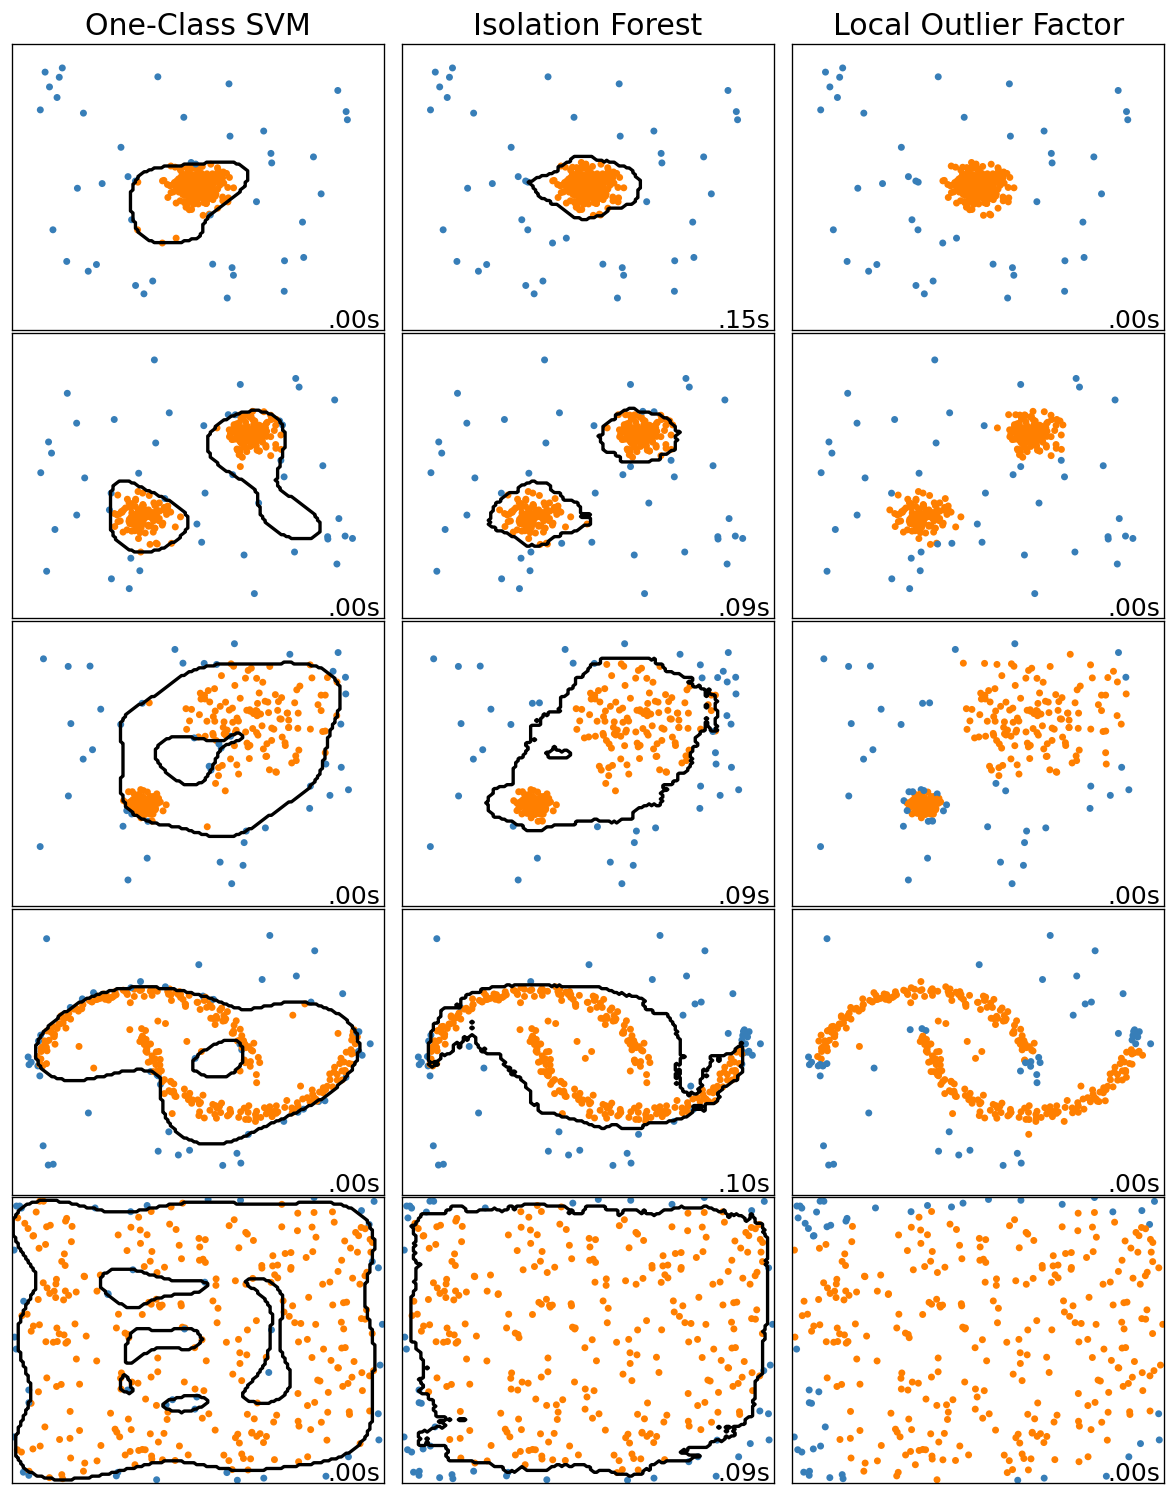

In [16]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.


anomaly_algorithms = [
    
    ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),

    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [ ]:
scores_anomaly = pd.DataFrame(
    columns=['silhouette', 'davies_bouldin', 'calinski_harabasz', 'duration'],
    index=[
        'OneClassSVM',
        'IsolationForest',
        'LocalOutlierFactor', 
        'DBSCAN', 
        'EllipticEnvelope'
    ]
)

In [ ]:
from sklearn import metrics
import time

def get_metrics(X, y_pred):
    silhouette = metrics.silhouette_score(X, y_pred)
    davies_bouldin = metrics.davies_bouldin_score(X, y_pred)
    calinski_harabasz = metrics.calinski_harabasz_score(X, y_pred)
    return pd.Series(
        (silhouette, davies_bouldin, calinski_harabasz),
        index=['silhouette', 'davies_bouldin', 'calinski_harabasz']
    )

In [ ]:
def test_anomaly_detection(dataset, algorithm):

    algorithm = algorithm
    X = np.array(dataset)

    start = time.time()
    algorithm.fit(X)
    y_pred = algorithm.fit_predict(X)
    end = time.time()

    n_features = X.shape[1]
    plt.figure(figsize=(6, 4))

    if n_features >= 2:
        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
    else:
        plt.hist(X[y_pred == 1], bins=30, alpha=0.5, color="#377eb8", label="Inliers")
        plt.hist(X[y_pred == -1], bins=30, alpha=0.5, color="#ff7f00", label="Outliers")
        plt.legend()
        
    plt.title(f"{algorithm}")
    plt.grid()

    duration = pd.Series([end - start])
    returned = pd.concat([get_metrics(X, y_pred), duration])
    return returned

#### Одноклассовый метод опорных векторов


Будем строить линейную функцию $a(x) = sign \langle w, x \rangle$, и потребуем,
чтобы она отделяла выборку от начала координат с максимальным отступом.
Соответствующая оптимизационная задача будет иметь следующий вид:

$$
\left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2
            +
            \frac{1}{\nu \ell} \sum_{i = 1}^{\ell} \xi_i
            -
            \rho
            \to \min_{w, \xi, \rho} \\
            & \langle w, x_i \rangle
            \geq
            \rho - \xi_i,
            \quad i = 1, \dots, \ell, \\
            & \xi_i \geq 0, \quad i = 1, \dots, \ell.
        \end{aligned}
\right.
$$


Здесь гиперпараметр $\nu$ отвечает за корректность на обучающей выборке -
можно показать, что он является верхней границей на число аномалий (объектов выборки,
на которых $a(x) = -1$).
Решающее правило будет иметь вид

$$
\
    a(x)
    =
    sign\left(
        \langle w, x \rangle
        -
        \rho
    \right),
\
$$
где ответ -1 будет соответствовать выбросу.

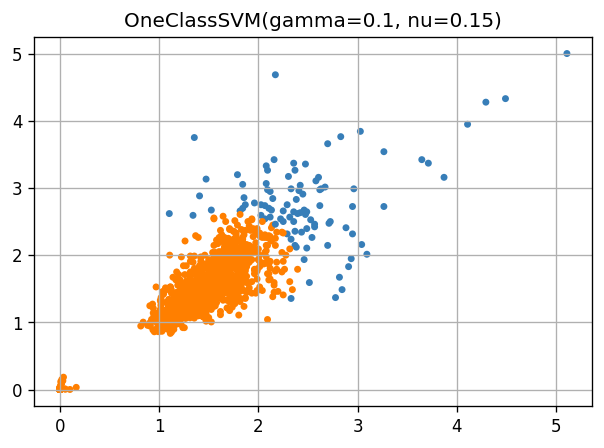

In [ ]:
from sklearn.svm import OneClassSVM

scores_anomaly.iloc[0] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], OneClassSVM(nu=0.15, kernel="rbf", gamma=0.1))

#### Isolation forest

На этапе обучения будем строить лес, состоящий из N деревьев.
Каждое дерево будем строить стандартным жадным алгоритмом,
но при этом признак и порог будем выбирать случайно.
Строить дерево будем до тех пор, пока в вершине не окажется ровно один объект,
либо пока не будет достигнута максимальная высота.


Метод основан на предположении о том, что чем сильнее объект отличается от большинства,
тем быстрее он будет отделён от основной выборки с помощью случайных разбиений.
Соответственно, выбросами будем считать те объекты, которые оказались на небольшой глубине.

Чтобы вычислить оценку аномальности объекта $x$, найдём расстояние от соответствующего ему листа
до корня в каждом дереве.
Если лист, в котором оказался объект, содержит только его, то в качестве оценки $h_n(x)$
от данного $n$-го дерева будем брать саму глубину $k$;
если же в листе оказалось $m$ объектов, то в качестве оценки возьмём величину $h_n(x) = k + c(m)$.
Здесь $c(m)$ - средняя длина пути от корня до листа в бинарном дереве поиска, которая вычисляется по формуле
$$
\
    c(m)
    =
    2H(m - 1) - 2\frac{m - 1}{m},
\
$$
а $H(i) \approx \ln(i) + 0.5772156649$ - $i$-е гармоническое число.
Оценку аномальности вычислим на основе средней глубины, нормированной на среднюю длину пути в дереве,
построенном на выборке размера $\ell$:
$$
\
    a(x)
    =
    2^{-\frac{
            \frac{1}{N} \sum_{n = 1}^{N} h_n(x)
        }{
            c(\ell)
        }
    }.
\
$$


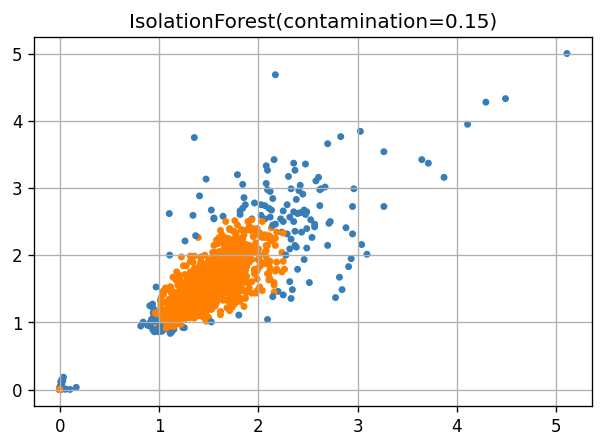

In [ ]:
from sklearn.ensemble import IsolationForest

scores_anomaly.iloc[1] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], IsolationForest(contamination=0.15))

#### Метрический метод LOF (Local Outlier Factor)

измерение локального отклонения плотности конкретной точки данных по отношению к ее соседям. Идея состоит в том, чтобы обнаружить наблюдения, которые имеют значительно меньшую плотность, чем их соседи. Именно эти точки и будут являться аномалиями. 

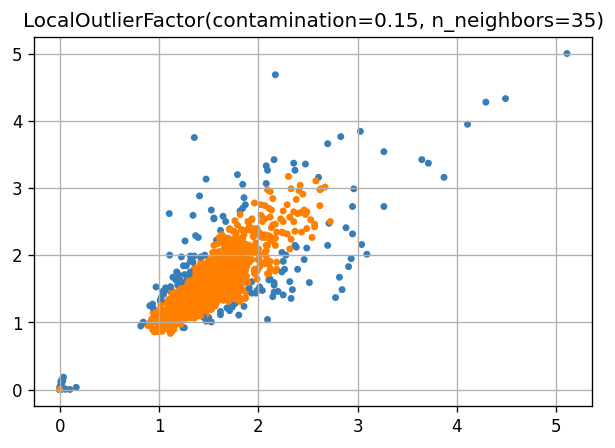

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

scores_anomaly.iloc[2] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], LocalOutlierFactor(n_neighbors=35, contamination=0.15))

#### Кластерный метод DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

группирует точки на основе их плотности, определяя кластеры как области с высокой плотностью. Точки в разреженных областях или не входящие в кластеры помечаются как аномалии.

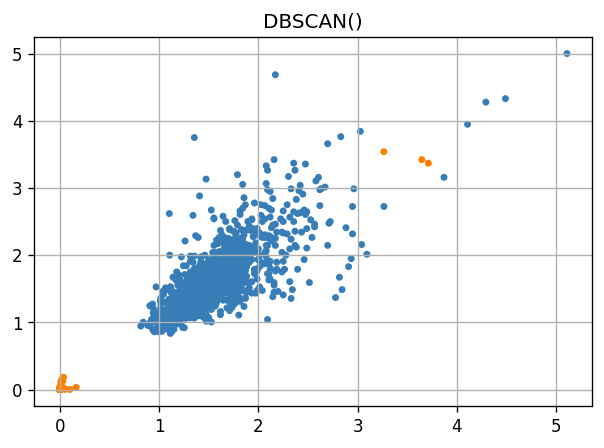

In [ ]:
from sklearn.cluster import DBSCAN

scores_anomaly.iloc[3] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], DBSCAN(eps=0.5, min_samples=5))

#### Статистический метод Elliptic Envelope (Robust Covariance)

предполагает, что нормальные данные следуют многомерному нормальному распределению. Аномалии выявляются как точки, лежащие за пределами эллиптической области, описывающей нормальные данные.

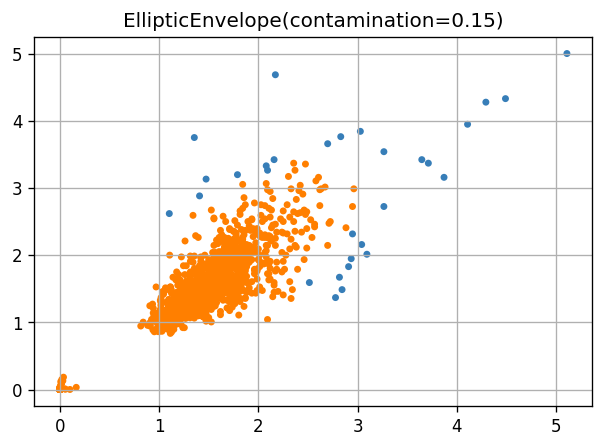

In [ ]:
from sklearn.covariance import EllipticEnvelope

scores_anomaly.iloc[4] = test_anomaly_detection(feature_engineering_data[['Income', 'Outcome']], EllipticEnvelope(contamination=0.15))

In [ ]:
scores_anomaly

,silhouette,davies_bouldin,calinski_harabasz,duration
OneClassSVM,0.428773,0.752599,374.72785,0.0368
IsolationForest,0.316653,3.55417,56.012812,0.1882
LocalOutlierFactor,0.231411,9.892871,6.227122,0.015917
DBSCAN,0.686485,1.180054,1320.499398,0.027638
EllipticEnvelope,0.507029,0.878363,144.97893,0.287546


- Silhouette Score (выше — лучше): насколько хорошо точки разделены на нормальные и аномальные
- Davies-Bouldin Index (ниже — лучше): компактность и разделимость кластеров
- Calinski-Harabasz Index (выше — лучше): отношение межкластерной дисперсии к внутрикластерной

DBSCAN доминирует по Silhouette и Calinski-Harabasz, но имеет средний Davies-Bouldin. На нем и остановимся, обеспечивает лучшее разделение нормальных точек и аномалий для данного датасета.


## Разладки

In [32]:
# округляем как в данных 8 цифр после запятой
# методы для создания синтетических данных с разными видами разладки


# 1. Разладка: Скачок среднего
def get_avg_shift_data(n, avg1,avg2,disp):
    data = np.round(np.concatenate([
    np.random.normal(avg1, disp, n),
    np.random.normal(avg2, disp, n)
]), 8)
    
    return data


# 2. Разладка: Увеличение дисперсии
def get_disp_shift_data(n,disp1,disp2,avg):
    data = np.round(np.concatenate([
    np.random.normal(avg, disp1, n),
    np.random.normal(avg, disp2, n)
]), 8)
    
    return data



# 3. Разладка: Линейный тренд
def get_lin_trend_data(n, avg, disp, k):
    trend = np.linspace(0, avg*k, n)
    data = np.round(np.concatenate([
    np.random.normal(avg, disp, n),
    avg + trend + np.random.normal(0, disp, n)
]), 8)
    
    return data



# 4. Разладка: Периодичность
def get_period_data(n, avg, disp, freq , d):
    x = np.arange(n)
    data = np.round(np.concatenate([
    np.random.normal(avg, disp, n),
    avg + d *np.sin(x*freq*np.pi/10) + np.random.normal(0, disp, n)
]), 8)
    
    return data

# Получение размеченных данных
def get_pd_razm(data, rasm_mark):
    df = pd.DataFrame({'data': data})
    df["shift_target"] = 0
    df["shift_target"][rasm_mark] = 1
    return df


data1 = get_avg_shift_data(10,5,8,0.5)
data2 = get_disp_shift_data(10,0.5,1,5)
data3 = get_lin_trend_data(10,5,0.3,0.5)
data4 = get_period_data(10, 5 , 0.5, 5, 2)

print("1. Скачок среднего:", data1)
print("2. Рост дисперсии:", data2)
print("3. Линейный тренд:", data3)
print("4. Периодичность:", data4)
# print("4. Периодичность:", type(data4))
print("Размеченные данные", get_pd_razm(data4,10))

1. Скачок среднего: [4.89363534 5.01814736 4.43122685 4.84744983 5.34099742 5.4455667
 4.69986914 4.95185224 5.29294437 5.00600421 8.19122462 8.21920038
 7.47661756 7.41056049 8.18793901 8.31700472 8.32382343 8.50007531
 7.67761758 7.56517027]
2. Рост дисперсии: [5.56580352 4.58212338 4.51442358 5.42035282 5.64085205 3.80531266
 5.40196029 4.75997172 5.67245697 5.27321067 6.16843676 4.36701572
 6.1468359  5.3374185  4.85194031 5.82150916 5.04478671 4.79759595
 3.92197962 4.74533812]
3. Линейный тренд: [4.9273473  4.42827907 5.40831535 4.56772133 5.42002182 4.71081464
 5.28126874 5.08691739 4.63707338 4.82811755 5.3798586  5.47752891
 5.65896999 6.03091937 5.93138263 6.10566274 6.27311939 6.48358397
 7.35685026 6.78648584]
4. Периодичность: [4.24151042 5.29441041 5.50023344 4.95958821 4.09569423 4.61039213
 5.87450053 5.75076883 5.25016626 5.33715679 5.79768311 7.47755625
 5.25234978 3.02722959 5.34661658 6.90768713 5.6875115  3.24436703
 5.69317585 6.82914908]
Размеченные данные       

In [33]:
# В этой части мы сделаем методы которые будут считать метрики по котрым будет выбран алгоритм поиска разладки


# • Хорошо : E∞τ → ∞ (редкие ложные тревоги)
# • E0τ или E∞[ τ − θ|τ > θ] : средняя задержка в обнаружении
# (average detection delay, ADD(τ ))
# • Хорошо : E0τ → 0 (быстрое обнаружение)

# • Плохо : Pθ(τ < θ) → 1 (частые ложные тревоги)
# • E0τ или Eθ[ τ − θ|τ > θ] : средняя задержка в обнаружении
# (average detection delay, ADD(τ ))
# • Плохо : Eθ(τ < θ) → ∞
# (медленное обнаружение)
# • В практике: задержка срабатывания ADD(τ )
# и время без ложных тревог FDD(τ ) — конфликтующие критерии (строится зависимость одного отдругого)




# задержка срабатывания
def detect_delay(target_col, predict_col):
    # Находим первую 1 в target_col
    shift_ind_target = target_col.eq(1).idxmax()
    
    # Выбираем часть predict_col после shift_ind_target
    predict_subset = predict_col[predict_col.index > shift_ind_target]
    
    # Проверяем есть ли 1 в этой части
    if predict_subset.eq(1).any():
        # Если есть, находим первую 1 и считаем задержку
        shift_ind_predict = predict_subset.eq(1).idxmax()
        return int(shift_ind_predict) - shift_ind_target
    else:
        # Если нет 1, возвращаем shift_ind_target * 5
        return shift_ind_target * 5



# среднее время до ложного срабатывания
def detect_wrong_delay( target_col, predict_col):
    shift_ind_target = target_col.eq(1).idxmax()
    num_wrong_detect = predict_col.loc[:shift_ind_target].eq(1).sum()
    return min(shift_ind_target/(num_wrong_detect+1),shift_ind_target+1)


# функция которую мы будем максимизировать на разных данных 
# будем пытаться увеличить время до ложного срабатывания и уменьшить время до правильного срабатывания
def shift_quality_metric(target_col, predict_col):
    return detect_wrong_delay( target_col, predict_col)/detect_delay(target_col,predict_col) 



In [34]:
target_col =  pd.Series([0, 0, 0, 1, 0, 0, 0, 0])

# Predict series (предсказание) с задержкой в 2 периода
predict_col = pd.Series([1, 1, 0, 0, 0, 0, 0, 1])

# Применяем функцию
delay = detect_delay(target_col, predict_col)
w_delay = detect_wrong_delay(target_col, predict_col)
q_metric = shift_quality_metric(target_col, predict_col)
print(f"Задержка: {delay}")  # Выведет 2 (разница индексов между первыми 1)
print(f"w_delay: {w_delay}")  # Выведет 2 (разница индексов между первыми 1)
print(f"shift_quality_metric: {q_metric}")  # Выведет 2 (разница индексов между первыми 1)

Задержка: 4
w_delay: 1.0
shift_quality_metric: 0.25


In [35]:




# генерим данные(так как мы не знаем какие у нас будут разладки будем готовится ко всем)

from sklearn.model_selection import ParameterGrid

def get_test_data():
    vectorized_avg_shift = np.vectorize(get_avg_shift_data, excluded=['n'])
    vectorized_disp_shift = np.vectorize(get_disp_shift_data, excluded=['n'])
    vectorized_lin_trend = np.vectorize(get_lin_trend_data, excluded=['n'])
    vectorized_period = np.vectorize(get_period_data, excluded=['n'])

    n = 2000
    avg_min = 0
    avg_max = 10
    disp_min = 0.1
    disp_max = 3
    k_min = -3
    k_max = 3
    freq_min = 0.1
    freq_max = 10
    d_min = 0.2
    d_max = 4
    n_iter = 1000 # нужно чтобы кол-во датасетов с периодами не было слишком много



    param_grid_avg = {
    'avg1': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/3)))),
    'avg2': np.linspace(avg_max*1.1, avg_max*2, num=int(np.round(n_iter**(1/3)))),
    'disp': np.linspace(disp_min, disp_max, num=int(np.round(n_iter**(1/3))))
}

    grid = ParameterGrid(param_grid_avg)
    results = []

    for params in grid:
        data = vectorized_avg_shift(n=n, **params)
        results.append(data)



    param_grid_disp = {
    'disp1': np.linspace(disp_min,disp_max, num=int(np.round(n_iter**(1/3)))),
    'disp2': np.linspace(disp_max*1.1, disp_max*2, num=int(np.round(n_iter**(1/3)))),
    'avg': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/3))))
}

    for params in ParameterGrid(param_grid_disp):
        data = vectorized_disp_shift(n=n, **params)
        results.append(data)


    param_grid_trend = {
    'avg': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/3)))),
    'disp': np.linspace(disp_min,disp_max, num=int(np.round(n_iter**(1/3)))),
    'k': np.linspace(k_min, k_max, num=int(np.round(n_iter**(1/3))))
}

    for params in ParameterGrid(param_grid_trend):
        data = vectorized_lin_trend(n=n, **params)
        results.append(data)


    param_grid_period = {
    'avg': np.linspace(avg_min, avg_max, num=int(np.round(n_iter**(1/4)))),
    'disp': np.linspace(disp_min,disp_max, num=int(np.round(n_iter**(1/4)))),
    'freq': np.linspace(freq_min, freq_max, num=int(np.round(n_iter**(1/4)))),
    'd': np.linspace(d_min, d_max, num=int(np.round(n_iter**(1/4))))
}

    for params in ParameterGrid(param_grid_period):
        data = vectorized_period(n=n, **params)
        results.append(data)

    rasm_res = []
    for a in results:
        rasm_res.append(get_pd_razm(a,n))
    return rasm_res

test_data = get_test_data()





In [36]:
test_data[0][test_data[0]["shift_target"]==1]

,data,shift_target
2000,10.969065,1


1. **Статистика кумулятивных сумм.**

 - Вводятся статистики $\gamma_t$ 
 и $T_t$ 
$$
\gamma_n = \sup\limits_{\theta \geqslant 0} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
 \qquad T_n = \log \gamma_n
$$

 - Если случайные величины
$X_1, \ldots, X_n$ независимы, то
$$
\gamma_n = \max\Big\{1, \max\limits_{1 \leqslant \theta \leqslant n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\}
$$
$$
T_n = \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \log \frac{f_{0}(X_k)}{f_{\infty}(X_k)} \Big\} = 
    \max\Big\{0, \max\limits_{1 \leqslant \theta \leqslant n} \sum\limits_{k=\theta}^{n}
    \zeta_k \Big\}
$$

 - Статистика $T_n$ обладает свойством $T_n = \max (0, T_{n-1} + \zeta_n)$
и называется статистикой кумулятивных сумм (CUmulative SUMs, CUSUM).

 - Момент остановки
$$
\tau_{\mathrm{CUSUM}} = \inf \{n \geqslant 0: T_n \geqslant B\},
$$
построенный по статистике кумулятивных сумм,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.

2. **Статистика Ширяева-Робертса.**

 - Вводится статистика
$$
R_n = \sum\limits_{\theta = 1}^{n} \frac{f_{\theta}(X_1, \ldots, X_n)}{f_{\infty}(X_1, \ldots, X_n)}
$$

 - Если случайные величины $X_1, \ldots, X_n$ независимы, то
$$
R_n = \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    \frac{f_{0}(X_k)}{f_{\infty}(X_k)} =
        \sum\limits_{\theta = 1}^{n} \prod\limits_{k=\theta}^{n}
    l_k.
$$ 

 - Статистика $R_n$ обладает свойством $R_n = (1 + R_{n-1}) l_k$ и~называется статистикой Ширяева-Робертса (Shiryaev-Roberts, SR).
 
 - Момент остановки 
$$
\tau_{\mathrm{SR}} = \inf \{n \geqslant 0: R_n \geqslant B\},
$$
построенный по статистике Ширяева-Робертса,
оптимален (т.\,е.~обладает наименьшей задержкой
в обнаружении разладки) в~классе
$$
\mathcal{M}_T = \{\tau : 
    {\textstyle \mathrm{E}_{\infty}} \tau \geqslant T\}
$$
тех моментов остановки, для которых среднее время
до~ложной тревоги не меньше $T$.

In [37]:
# методы для выявления разладки

class CUSUM:
    def __init__(self, data, k, h):
        self.data = data
        self.target = data.mean()
        self.k = np.var(data) * k
        self.h = np.var(data) * k + h
        self.S_upper = 0
        self.S_lower = 0

    def update(self, num):
        self.S_upper = max(0, self.S_upper + (num - self.target - self.k))
        self.S_lower = max(0, self.S_lower + (self.target - self.k - num))
        
        if self.S_upper > self.h or self.S_lower > self.h:
            return 1
        return 0






In [38]:

class ShiryaevRobertsDetector:
    def __init__(self,data, threshold, h, window_size=5):
        """
        mu: величина сдвига среднего (для отношения правдоподобия).
        threshold: порог обнаружения разладки.
        """
        self.mu = data.mean()
        self.threshold = np.var(data) * threshold + h
        self.var = np.var(data)
        self.R = 0
        self.steps = 0
        self.window_size = window_size
        self.R_history = []
    
    
    def update(self, x):
        """
        Обновляет статистику ШР для нового наблюдения x.
        Возвращает:
            - текущее значение R,
            - флаг срабатывания (True, если R > порога).
        """
        self.steps += 1
        likelihood_ratio = np.exp((self.mu * x - self.mu**2 / 2)/self.var)
        self.R = (1 + self.R) * likelihood_ratio
        self.R_history.append(self.R)
        
        # Суммируем последние window_size значений R
        sum_last_R = sum(self.R_history[-self.window_size:])/self.window_size
        
        if sum_last_R > self.threshold:
            return 1
        return 0


Предполагается что в детектор будут попадать данные ошибок предсказаний
В общем смысл этих тестов в том что мы пытаемся подобрать универсальный детектор разладок так как мы не можем знать какая разладка у нас случится и мы должны быть готовы к любой(по сути этого мы добиваемся разными данными) метрика которую мы выбрали shift_quality_metric должна максимизировать полезность наших параметров. При создании детектора указывается параметр data который берет некоторые статы с данных чтобы привязывать трешхолды сигналов к данным (чтобы детектор был универсальным). Для примера трешхолд для данных с высокой дисперсией должен больше чем для данных с низкой дисперсией и поэтому константа нам не подходит

In [39]:
def evaluate_cusum_flags(data, k, h):
    train = 1000
    detector = CUSUM(data["data"][:1000], k, h)
    # Применяем детектор к данным после обучающей выборки
    flags = data['data'].iloc[train:-train].apply(lambda x: int(detector.update(x)))
    
    return shift_quality_metric(
        data['shift_target'].iloc[train:-train],
        flags
    )

# Диапазоны параметров
k_values = np.linspace(0.1, 2.0, 3)
h_values = np.linspace(1, 10, 3)

best_score = -1
best_k = None
best_h = None


for k in k_values:
    for h in h_values:
        score = 0
        for data in test_data:
            score = score + evaluate_cusum_flags(data, k, h)
        if score > best_score:
            best_score = score
            best_k = k
            best_h = h
print(f"Лучшие параметры CUSUM: best_k={best_k}, best_h={best_h}, метрика: {best_score}")

KeyboardInterrupt: 

In [ ]:
def evaluate_sr_flags(data, threshold, h):
    train = 1000
    detector = ShiryaevRobertsDetector(data["data"][:train], threshold, h)
    
    # Применяем детектор к данным после обучающей выборки
    flags = data["data"].iloc[train:-train].apply(lambda x: int(detector.update(x)))
    
    return shift_quality_metric(
        data["shift_target"].iloc[train:-train],
        flags
    )

# Диапазоны параметров для SR-детектора
threshold_values = np.linspace(0.0, 3.0, 10)
h_values = np.linspace(0, 10, 10)

best_score = -1
best_threshold = None
best_h = None

for threshold in threshold_values:
    for h in h_values:
        score = 0
        for data in test_data:
            score += evaluate_sr_flags(data,  threshold, h)
        if score > best_score:
            best_score = score
            best_threshold = threshold
            best_h = h

print(f"Лучшие параметры SR: threshold={best_threshold}, h={best_h}, метрика: {best_score}")

Лучшие параметры SR: threshold=3.0, h=10.0, метрика: 8559.789018367537


In [ ]:
df_pred = pd.read_csv("data/predict_vremen_ryad.csv")
df_pred["delay"] = df_pred["y_pred"]-df_pred["y_test"]
df_test = df_pred["delay"][100:].to_frame()
# CUSUM: best_k=1.05, best_h=5.5, метрика: 1592102.2834922085
cusum = CUSUM(df_pred["delay"][:100], 1.05, 5.5)

df_test['shift'] = df_test['delay'].apply(cusum.update)
has_one_shift = (df_test['shift'] == 1).any()
print(f"В столбце 'shift' есть 1: {has_one_shift}")
# мы знаем что в наших данных нет разладок но удостоверились в этом нашим детектором

В столбце 'shift' есть 1: False


Получили универсальный детектор который по крайней мере ложно не срабатывает и быстро обнаруживает разладки судя по скору

# Модуль отбора фичей

In [ ]:
data = feature_engineering_data.copy()

target = 'Balance'
features = [col for col in data.columns if col not in ['Date', target]]

X = data[features]
y = data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

##### Встроенные методы отбора признаков
**RandomForestRegressor**

ансамбль деревьев решений, где каждое дерево обучается на случайной подвыборке данных и признаков. Для отбора фичей используется важность признаков, рассчитанная на основе того, насколько каждый признак уменьшает ошибку предсказания (например, дисперсию). Признаки с большей важностью считаются более значимыми.

исследует нелинейную зависимость

(34,)


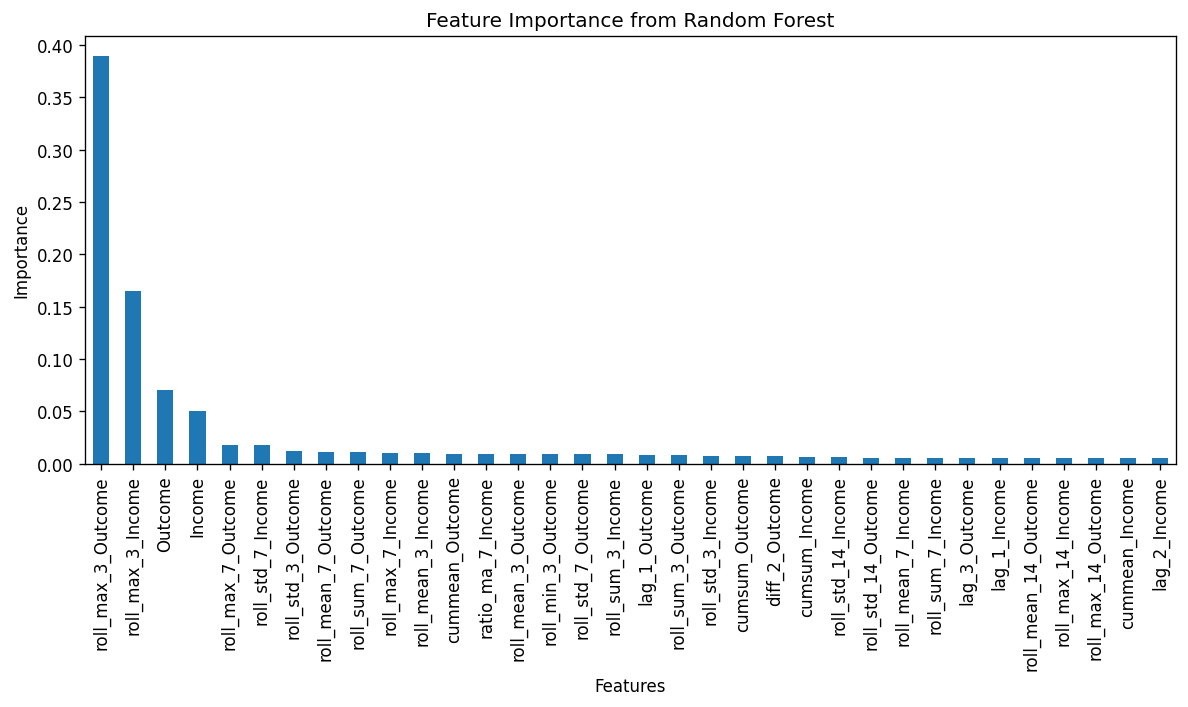

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y)

feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
selected_features = feature_importance[feature_importance > 0.005]

selected_features_RandomForestRegressor = selected_features.index.tolist()
print(selected_features.shape)

plt.figure(figsize=(10, 6))
selected_features.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

#### Оберточные методы отбора признаков
оценивают подмножества признаков, обучая модель на каждом подмножестве и измеряя ее производительность

**RFE (Recursive Feature Elimination)**

Метод рекурсивного исключения признаков. Последовательно удалет наименее важные фичи на основе весов модели и оценивает производительность, пока не останется заданное количество признаков

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=30)
rfe.fit(X_scaled, y)

selected_features_RFE = X_scaled.columns[rfe.support_].tolist()
X_scaled.columns[rfe.support_].shape

(30,)

#### Фильтрационные методы отбора признаков

**Mutual Information Regression**

измеряет взаимную информацию между признаком и целевой переменной, оценивая, насколько признак уменьшает неопределенность о целевой переменной. Используется для отбора фичей: признаки с высокой взаимной информацией считаются более информативными и предпочтительными для модели.

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_scaled, y)
mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)
selected_features_mutual_info = mi_scores[mi_scores > 0.1].index.tolist()
mi_scores[mi_scores > 0.1].shape

(46,)

In [ ]:
features_RandomForestRegressor = feature_engineering_data[selected_features_RandomForestRegressor]
features_mutual_info = feature_engineering_data[selected_features_mutual_info]
features_RFE = feature_engineering_data[selected_features_RFE]

# Модуль оценки стабильности признаковой выборки

Проанализируем методы, согласно статье "Quantifying the stablility of feature selection"

В ней стабильность выборки оценивается по бинарной матрице, где значениями является факт попадания признака в текущую выборку

In [ ]:
def jaccard_index(Z):
    """
    Jaccard Index: Отношение размера пересечения к объединению двух подмножеств признаков.
    Формула: \hat{\Phi}_{\text{Jaccard}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j|}{|s_i \cup s_j|}
    """ы
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            union = np.sum(Z[i] | Z[j])
            if union > 0:  # Избегаем деления на 0
                stability += intersection / union
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

In [ ]:
def dice_sorensen_index(Z):
    """
    Dice-Sørensen Index: Нормализованное пересечение, акцентирует внимание на совпадающих признаках.
    Формула: \hat{\Phi}_{\text{Dice}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{2|s_i \cap s_j|}{|s_i| + |s_j|}
    """
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            if size_i + size_j > 0:  # Избегаем деления на 0
                stability += 2 * intersection / (size_i + size_j)
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

In [ ]:
def pog(Z):
    """
    Percentage Overlapping Genes (POG): Симметричная мера, учитывающая долю пересечения относительно размеров подмножеств.
    Формула: \hat{\Phi}_{\text{POG}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \left( \frac{|s_i \cap s_j|}{2|s_i|} + \frac{|s_i \cap s_j|}{2|s_j|} \right)
    """
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            if size_i > 0 and size_j > 0:  # Избегаем деления на 0
                stability += (intersection / (2 * size_i) + intersection / (2 * size_j))
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

In [ ]:
def ochiai_index(Z):
    """
    Ochiai’s Index: Геометрическое среднее доли общих признаков, устойчиво к различиям в размерах подмножеств.
    Формула: \hat{\Phi}_{\text{Ochiai}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j|}{\sqrt{|s_i||s_j|}}
    """
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            if size_i > 0 and size_j > 0:  # Избегаем деления на 0
                stability += intersection / np.sqrt(size_i * size_j)
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

In [ ]:

def normalized_hamming(Z):
    """
    Normalized Hamming Similarity: Основана на симметричной разнице, учитывает ложноположительные и ложноотрицательные выборы.
    Формула: \hat{\Phi}_{\text{Hamming}}(\mathcal{Z}) = 1 - \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \triangle s_j|}{d}
    """
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            symmetric_diff = np.sum(Z[i] ^ Z[j])  # XOR для симметричной разницы
            stability += symmetric_diff / d
    return 1 - (stability * 2 / (M * (M - 1))) if M > 1 else 0

In [ ]:
def kuncheva_index(Z):
    """
    Kuncheva’s Index: Корректирует пересечение с учетом случайного совпадения, предполагая гипергеометрическое распределение.
    Формула: \hat{\Phi}_{\text{Kuncheva}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j| - \frac{|s_i||s_j|}{d}}{|s_i| - \frac{|s_i||s_j|}{d}}
    """
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            expected = size_i * size_j / d
            denominator = size_i - expected
            if denominator > 0:  # Избегаем деления на 0
                stability += (intersection - expected) / denominator
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

In [ ]:
def npog(Z):
    """
    Normalized POG (nPOG): Нормализованная версия POG, пытается учесть случайное совпадение.
    Формула: \hat{\Phi}_{\text{nPOG}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j| - \frac{|s_i||s_j|}{d}}{|s_i|}
    """
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            expected = size_i * size_j / d
            if size_i > 0:  # Избегаем деления на 0
                stability += (intersection - expected) / size_i
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

In [ ]:
def wald_measure(Z):
    """
    Wald’s Measure: Похожа на Kuncheva’s, но с другой нормализацией.
    Формула: \hat{\Phi}_{\text{Wald}}(\mathcal{Z}) = \frac{1}{M(M-1)} \sum_{i \neq j} \frac{|s_i \cap s_j| - \frac{|s_i||s_j|}{d}}{1 - \frac{|s_i||s_j|}{d}}
    """
    M, d = Z.shape
    stability = 0
    for i in range(M):
        for j in range(i + 1, M):
            intersection = np.sum(Z[i] & Z[j])
            size_i = np.sum(Z[i])
            size_j = np.sum(Z[j])
            expected = size_i * size_j / d
            denominator = 1 - expected
            if denominator != 0:  # Избегаем деления на 0
                stability += (intersection - expected) / denominator
    return stability * 2 / (M * (M - 1)) if M > 1 else 0

In [ ]:

def goh_measure(Z):
    """
    Goh’s Measure: Средняя частота выбора признаков.
    Формула: \hat{\Phi}_{\text{Goh}}(\mathcal{Z}) = \frac{\bar{k}}{d}
    """
    M, d = Z.shape
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    return k_bar / d

In [ ]:


def krizek_measure(Z):
    """
    Krízek’s Measure: Энтропия распределения подмножеств признаков, низкая энтропия = высокая стабильность.
    Формула: \hat{\Phi}_{\text{Krizek}}(\mathcal{Z}) = -\sum_{s_i \in \mathcal{Z}} \hat{p}(s_i) \log_2 \hat{p}(s_i)
    """
    M, d = Z.shape
    # Преобразуем строки Z в строки для подсчета уникальных подмножеств
    sets = [tuple(row) for row in Z]
    unique_sets, counts = np.unique(sets, axis=0, return_counts=True)
    probs = counts / M
    entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Добавляем малое значение для избежания log(0)
    return entropy

In [ ]:

def guzman_measure(Z):
    """
    Guzmán-Martínez’s Measure: Энтропия частот выбора признаков, нормализована для коррекции случайного выбора.
    Формула: \hat{\Phi}_{\text{Guzman}}(\mathcal{Z}) = 1 - \frac{\frac{1}{d} \sum_{f=1}^d \hat{p}_f \log \hat{p}_f}{\frac{1}{d} \log \left(\frac{1}{d}\right)}
    """
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора признаков
    entropy = np.sum(p_f * np.log(p_f + 1e-10)) / d  # Средняя энтропия, избегаем log(0)
    denominator = np.log(1 / d) / d
    return 1 - (entropy / denominator) if denominator != 0 else 0


In [ ]:

def cw_rel(Z):
    """
    Relative Weighted Consistency (CW_rel): Учитывает дисперсию частот выбора с коррекцией на размер подмножеств.
    Формула: \hat{\Phi}_{CW_{\text{rel}}}(\mathcal{Z}) = \frac{-\frac{1}{d} \frac{M-1}{M} \sum_{f=1}^d s_f^2 + \frac{\bar{k}}{d}\left(1-\frac{\bar{k}}{d}\right) - \frac{D}{M^2 d}\left(1-\frac{D}{d}\right)}{\frac{\bar{k}}{d}\left(1-\frac{\bar{k}}{d}\right) - \frac{D}{M^2 d}\left(1-\frac{D}{d}\right) + \frac{H^2}{M^2 d} - \frac{H}{Md}}
    """
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора
    s_f2 = p_f * (1 - p_f)  # Дисперсия для каждого признака
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    k_i = np.sum(Z, axis=1)  # Число признаков в каждой выборке
    D = np.sum(k_i**2) / M
    H = (M * k_bar) % M
    numerator = (-np.sum(s_f2) * (M-1) / (M * d)) + (k_bar / d) * (1 - k_bar / d) - (D / (M**2 * d)) * (1 - D / d)
    denominator = (k_bar / d) * (1 - k_bar / d) - (D / (M**2 * d)) * (1 - D / d) + (H**2 / (M**2 * d)) - (H / (M * d))
    return numerator / denominator if denominator != 0 else 0

In [ ]:

def lausser_measure(Z):
    """
    Lausser’s Measure: Среднее квадратов частот выбора, акцентирует внимание на доминирующих признаках.
    Формула: \hat{\Phi}_{\text{Lausser}}(\mathcal{Z}) = \frac{1}{\bar{k}} \sum_{f=1}^d \hat{p}_f^2
    """
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    return np.sum(p_f**2) / k_bar if k_bar > 0 else 0

In [ ]:

def proposed_measure(Z):
    """
    Proposed Measure: Новая мера, основанная на дисперсии частот выбора признаков, с коррекцией на случайное совпадение.
    Формула: \hat{\Phi}(\mathcal{Z}) = 1 - \frac{\frac{1}{d} \frac{M}{M-1} \sum_{f=1}^d \hat{p}_f(1-\hat{p}_f)}{\frac{\bar{k}}{d}\left(1-\frac{\bar{k}}{d}\right)}
    """
    M, d = Z.shape
    p_f = np.mean(Z, axis=0)  # Частоты выбора
    variance = np.sum(p_f * (1 - p_f)) / d  # Средняя дисперсия
    k_bar = np.sum(Z) / M  # Среднее число выбранных признаков
    denominator = (k_bar / d) * (1 - k_bar / d)
    if denominator > 0 and M > 1:
        return 1 - (variance * M / (M - 1)) / denominator
    return 0

In [ ]:
features_RandomForestRegressor = feature_engineering_data[selected_features_RandomForestRegressor]
features_mutual_info = feature_engineering_data[selected_features_mutual_info]
features_RFE = feature_engineering_data[selected_features_RFE]

In [ ]:
jaccard_index(np.array(features_RandomForestRegressor))

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
features_RandomForestRegressor.isna().sum().sum()

np.int64(0)

In [ ]:
np.array(features_RandomForestRegressor)

array([[1.22006379, 1.11071776, 0.96709981, ..., 1.44836401, 0.80268032,
        0.        ],
       [1.22006379, 1.11071776, 1.19372664, ..., 1.44836401, 0.81899113,
        1.11071776],
       [1.19372664, 1.07996407, 1.11235927, ..., 1.44836401, 0.82784138,
        1.04047577],
       ...,
       [4.68743261, 2.35688325, 3.37073806, ..., 4.68743261, 1.08317286,
        0.        ],
       [3.37073806, 2.35688325, 2.56755438, ..., 4.68743261, 1.08397325,
        0.        ],
       [3.37073806, 2.52805354, 2.52805354, ..., 4.68743261, 1.08490914,
        2.35688325]], shape=(1302, 34))

In [ ]:
Z = np.array([
    [1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    [1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 1, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 0, 1, 0, 0, 0, 1, 0]
], dtype=bool)
Z 

array([[ True,  True, False, False,  True, False, False, False,  True,
        False],
       [ True,  True, False, False,  True, False, False, False,  True,
        False],
       [ True, False,  True, False,  True, False, False, False, False,
         True],
       [False,  True, False,  True, False,  True, False, False, False,
         True],
       [ True,  True, False, False,  True, False, False, False,  True,
        False]])

In [ ]:


measures = [
    ("Jaccard Index", jaccard_index),
    ("Dice-Sørensen Index", dice_sorensen_index),
    ("POG", pog),
    ("Ochiai’s Index", ochiai_index),
    ("Normalized Hamming", normalized_hamming),
    ("Kuncheva’s Index", kuncheva_index),
    ("nPOG", npog),
    ("Wald’s Measure", wald_measure),
    ("Goh’s Measure", goh_measure),
    ("Krízek’s Measure", krizek_measure),
    ("Guzmán-Martínez’s Measure", guzman_measure),
    ("CW_rel", cw_rel),
    ("Lausser’s Measure", lausser_measure),
    ("Proposed Measure", proposed_measure)
]

for name, func in measures:
    print(f"{name}: {func(Z):.4f}")

In [ ]:
import sklearn
from sklearn import metrics
import scipy.io as sio
import math

def getMutualInfos(data,labels):
    '''
    This function takes as input the data and labels and returns the mutual information of each feature 
    with the labels in a np.dnarray of length d
    
    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data
    
    OUPUT:
    - a 1-dimensional numpy.ndarray of length d (where d is the number of features) 
      with the mutual information of each feature with the label
    '''
    M,d=data.shape
    mutualInfos=np.zeros(d)
    # for each feature
    for f in range(d):
        # we calculate the mutual information of the feature with the labels
        mutualInfos[f]=metrics.mutual_info_score(data[:,f],labels)
    return mutualInfos


def getBootstrapSample(data,labels):
    '''
    This function takes as input the data and labels and returns 
    a bootstrap sample of the data, as well as its out-of-bag (OOB) data
    
    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data
    
    OUPUT:
    - a dictionnary where:
          - key 'bootData' gives a 2-dimensional numpy.ndarray which is a bootstrap sample of data
          - key 'bootLabels' is a 1-dimansional numpy.ndarray giving the label of each example in bootData
          - key 'OOBData' gives a 2-dimensional numpy.ndarray the OOB examples
          - key 'OOBLabels' is a 1-dimansional numpy.ndarray giving the label of each example in OOBData
    '''
    m,d=data.shape
    if m!= len(labels):
        raise ValueError('The data and labels should have a same number of rows.')
    ind=np.random.choice(range(m), size=m, replace=True)
    OOBind=np.setdiff1d(range(m),ind, assume_unique=True)
    bootData=data[ind,]
    bootLabels=labels[ind]
    OOBData=data[OOBind,]
    OOBLabels=labels[OOBind]
    return {'bootData':bootData,'bootLabels':bootLabels,'OOBData':OOBData,'OOBLabels':OOBLabels}

def generateAtificialDataset(m,d,d_rel,rho):
    ''' This function enerates the artificial dataset used in the experiments (Section 7.1) of [1].
        The data set is made of continuous data where the first
        d_rel featues are relevant and where the d-d_rel remaining features are irrelevant to the target class
        this is a balanced data set where m/2 examples belong to class -1 and m/2 to class 1
        
        INPUTS:
        m is the number of samples
        d is the number of features/variables
        d_rel is the number of relevant features
        rho is the degree of redundancy (should be between 0 and 1)
        
        OUPUTS:
        A dictionnary with the data and the labels
    '''
    if d_rel>=d:
        raise ValueError('The input number of relevant features d_rel must be strictly less than the total number of features d')
    if rho<0 or rho >1:
        raise ValueError('The input argument rho controlling the degree of redundancy between the relevant features must be a value between 0 and 1.');
    num_positives=int(m/2) ## Take half instances as positive examples
    num_negatives=m-num_positives
    labels=np.concatenate((np.ones((num_positives),dtype=np.int8),-np.ones((num_negatives),dtype=np.int8)))
    mu_plus=np.concatenate((np.ones((d_rel),dtype=np.int8),np.zeros((d-d_rel)))) ## mean of the positive examples
    mu_minus=np.concatenate((-np.ones((d_rel),dtype=np.int8),np.zeros(d-d_rel)))  ## mean of the negative examples
    Sigma_star=rho*np.ones((d_rel,d_rel),dtype=np.int8)+(1-rho)*np.eye(d_rel)
    sub1=np.concatenate((Sigma_star,np.zeros((d_rel,d-d_rel))))
    sub2=np.concatenate((np.zeros((d-d_rel,d_rel)),np.eye(d-d_rel)))
    Sigma=np.concatenate((sub1,sub2),axis=1) ## the covariance matrix
    positive_ex=np.random.multivariate_normal(mu_plus, Sigma,num_positives)
    negative_ex=np.random.multivariate_normal(mu_minus, Sigma,num_negatives)
    data=np.concatenate((positive_ex,negative_ex),axis=0)
    ## we randomly permute the examples...
    order=ind=np.random.choice(range(m), size=m, replace=False)
    data=data[order,]
    labels=labels[order]
    trueRelevantSet=np.zeros(d)
    trueRelevantSet[range(d_rel)]=1
    return {'data':data,'labels':labels,'trueRelevantSet':trueRelevantSet}


# Оптимизация стабильности и точности регуляризованных методов

Мы выбираем гиперпараметры, используемые для создания искусственного набора данных, как показано в [1].
Мы создаем набор данных с числом объектов d=100, в котором только первые объекты d<sub>rel</sub> относятся к целевому классу.
Мы выбрали среднюю степень избыточности rho=0,5.
Количество выборок bootstrap, выбранных для количественной оценки стабильности, равно M=100.

In [ ]:
## we pick the hyper-parameters to generate the aritifical dataset
m=1000 # number of samples
d=100 # number of features 
d_rel=50 # the first d_rel features are relevant
rho=0.5 # the degree of redundancy between the relevant features
M=100 # number of bootstrap samples
res=generateAtificialDataset(m,d,d_rel,rho)
data=res['data']
labels=res['labels']

Мы применяем L1-логистическую регрессию с различными регуляризующими параметрами lambda к M выборкам данных bootstrap с использованием пакета scikit-learn. Мы сообщаем о стабильности, как указано в [1], и повторяем среднюю ошибку "вне пакета" (OOB) для них.

In [ ]:
!pip3 install stability

In [ ]:
from sklearn import linear_model
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy.stats import norm
import stability as st

## First, we pick the hyper-parameters 
alpha=0.05 # the level of significance for confidence intervals and hypothesis tests
num_lambdas=10
lambdas=np.linspace(-2,-1,num_lambdas)
lambdas=np.power(10,lambdas) ## this gives us lambda values between 10e-2 and 10e-1 (lambda is the regularising parameter)
Z=np.zeros((num_lambdas,M,d),dtype=np.int8)
errors=np.zeros((M,num_lambdas))
stabilities=np.zeros(num_lambdas)
errStab=np.zeros(num_lambdas)
numFeatSelected=np.zeros((M,num_lambdas),dtype=np.int32)
## for each repeat
for i in range(M):
    newData=getBootstrapSample(data,labels) ## we get a bootstrap sample
    for k in range(num_lambdas):
        logistic = LogisticRegression(penalty='l1',solver='liblinear',C=lambdas[k],max_iter=100) ## We use logostic LASSO
        logistic.fit(newData['bootData'],newData['bootLabels'])  ## we fit the coefficients 
        Z[k,i,:]=sum(logistic.coef_!=0)
        numFeatSelected[i,k]=sum(sum(logistic.coef_!=0))
        predLabels=logistic.predict(newData['OOBData'])
        errors[i,k]=1-metrics.accuracy_score(newData['OOBLabels'], predLabels)
meanError=np.mean(errors,0)
errCI=norm.ppf(1-alpha/2)*(np.std(errors,0))/math.sqrt(M)

for k in range(num_lambdas):
    res=st.confidenceIntervals(Z[k,:,:],alpha=alpha) ## we get the confidence intervals using the stability package
    stabilities[k]=res['stability']
    errStab[k]=stabilities[k]-res['lower']
    

AttributeError: module 'stability' has no attribute 'confidenceIntervals'

Давайте сначала построим график количества выбранных объектов по мере увеличения регуляризующего параметра lambda.

In [ ]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(numFeatSelected,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('num. Features selected')
plt.title('Number of Features selected against Lambda')
plt.show()

Как мы и ожидали, количество выбранных функций уменьшается по мере того, как мы увеличиваем регуляризацию. <br>
Давайте теперь построим график средней ошибки OOB в зависимости от лямбда-выражения.

In [ ]:
plt.close()
plt.figure()
plt.plot(lambdas,np.mean(errors,0),marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Av. error')
plt.title('Average OOB Error')
plt.show()

Давайте построим график зависимости стабильности от лямбда-выражения, используя 95% доверительные интервалы (используя пакет стабильности).

In [ ]:
plt.close()
plt.figure()
plt.errorbar(1/lambdas,stabilities,yerr=errStab,marker='o', linestyle='--')
plt.xlabel('lambda')
plt.ylabel('Stability')
plt.title('Stability against Lambda')
plt.show()

Мы можем построить график зависимости стабильности от ошибки OOB.

In [ ]:
plt.close()
plt.figure()
plt.errorbar(meanError,stabilities,yerr=errStab,marker='o', linestyle='--')
plt.xlabel('Error')
plt.ylabel('Stability')
plt.title('Stability against Av. OOB Error')
plt.show()

ВЫВОД:<br>
Как мы можем видеть из этих рисунков, значение регуляризующего параметра, которое обеспечивает максимальную стабильность (из 10 выбранных регуляризирующих параметров), не является значением, дающим минимальную погрешность. Здесь необходимо найти компромисс между погрешностью и стабильностью.Тем не менее, мы видим, что небольшая жертва с точки зрения точности может в значительной степени улучшить стабильность.

<b> ИСПОЛЬЗОВАНИЕ ЭЛАСТИЧНОЙ СЕТКИ </b> <br>
В этом разделе мы воспроизводим эксперименты на том же наборе данных с использованием эластичной сетки.

In [ ]:
## we use the ElasticNet package from scikit-learn
from sklearn.linear_model import ElasticNet

M=30 ## for computational reasons, we reduce M to 30 here. 
## This will give us larger confidence intervals and more variance in the stability estimates
## Nevertheless, we have shown in the paper [1] that M=30 suffices in most scenarios
num_ratios=10
num_alphas=10
alphas=np.linspace(0.05,0.95,num_alphas) ## the first hyper-parameter of the elastic net
ratios=np.linspace(0.01,0.8,num_ratios)  ## the second hyper-parameter of the elastic net
Z_net=np.zeros((num_ratios,num_alphas,M,d),dtype=np.int8)
errors_net=np.zeros((M,num_ratios,num_alphas))
stabilities_net=np.zeros((num_ratios,num_alphas))
errStab_net=np.zeros((num_ratios,num_alphas))
numFeatSelected_net=np.zeros((M,num_ratios,num_alphas),dtype=np.int32)
for i in range(M):
    newData=getBootstrapSample(data,labels) ## we get bootstrap samples
    for k in range(num_ratios):
        for l in range(num_alphas):
            net=ElasticNet(alpha=alphas[l],l1_ratio=ratios[k],max_iter=500) ## we use elastic net
            net.fit(newData['bootData'],newData['bootLabels'])
            Z_net[k,l,i,net.coef_!=0]=1
            numFeatSelected_net[i,k,l]=np.sum(Z_net[k,l,i,],axis=0)
            predLabels_net=np.zeros(len(newData['OOBData']))
            temp=net.predict(newData['OOBData'])
            for j in range(len(newData['OOBData'])):
                if temp[j]>=0: predLabels_net[j]=1
                else:  predLabels_net[j]=-1
            errors_net[i,k,l]=1-metrics.accuracy_score(newData['OOBLabels'], predLabels_net)
meanError_net=np.mean(errors_net,0)

for k in range(num_ratios):
    for l in range(num_alphas):
        ## we use the stability package to get the stability estimate and its confidence intervals
        res=st.confidenceIntervals(Z_net[k,l,],alpha=alpha)    
        stabilities_net[k,l]=res['stability']
        errStab_net[k,l]=stabilities_net[k,l]-res['lower']
    

На графике выше каждая линия представляет различные параметры соотношения эластичной сетки. <br>
Поскольку эти эксперименты служат лишь иллюстративной цели, мы не возражали против сходимости алгоритма оптимизации эластичной сети и сохранили максимальное число итераций равным 500. <br><br>

На всех рисунках ниже каждая линия соответствует определенному гиперпараметру ratio, а каждая точка линии соответствует другому значению альфа (второму гиперпараметру сети ealstic).

In [ ]:
import matplotlib.pyplot as plt
plt.close()
plt.figure()
numFeatSelected_net[i,k,l]
for k in range(num_ratios):
    plt.plot(alphas,np.mean(numFeatSelected_net[:,k,:],axis=0))
plt.xlabel('alphas')
plt.ylabel('num. Features selected against alpha for different L1-ratios')
plt.title('Number of Features selected against the L1-Ratio in Elastic Net')
plt.show()

In [ ]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(alphas,stabilities_net[k,:],yerr=errStab_net[k,:])
plt.xlabel('alpha')
plt.ylabel('Stability')
plt.title('Stability against alpha for different L1-ratios')
plt.show()

In [ ]:
plt.close()
plt.figure()
for k in range(num_ratios):
    plt.errorbar(meanError_net[k,:],stabilities_net[k,:],yerr=errStab_net[k,:])
plt.xlabel('Error')
plt.ylabel('Stability')
plt.title('Stability against Av. OOB Error')
plt.show()

ВЫВОДЫ:<br>
Как мы видим, гиперпараметры, оптимизирующие погрешность нашей модели, отличаются от тех, которые оптимизируют стабильность. <br>
Тем не менее, мы видим, что в этом случае можно выбрать разумный компромисс между ними, с высокой стабильностью и низкой ошибкой.

### Пример из теории информации

Давайте предположим, что теперь мы выбираем топ-k объектов, которые обладают наибольшей взаимной информацией с целевым классом. <br>
Мы проверяем стабильность этой процедуры выбора признака в сравнении с k в примере ниже. <br>
Для этой цели мы используем набор данных heart из репозитория UCI, где мы дискретизировали объекты, используя 10 ячеек, как это сделано в [3] (набор данных доступен по адресу [4]).

In [ ]:
## We set the chosen hyper-parameters
M=100
dataName='heartEW.mat'
kValues=range(1,d-1) ## an array with the number of features we want to select
## We load the desired dataset
res=sio.loadmat(dataName)
data=res['data']
labels=res['labels']
m,d=data.shape
labels=labels.reshape(m)
Z=np.zeros((len(kValues),M,d),dtype=np.int8) # this will store the M feature sets
for i in range(M):
    newData=getBootstrapSample(data,labels) ## we get bootstrap samples
    mutualInfos=getMutualInfos(newData['bootData'],newData['bootLabels']) ## we get the mutual informaion on the bootstrap samples
    ind=np.argsort(mutualInfos) #sorts the mutual informations in increasing order
    for j in range(len(kValues)):
        ## we retrieve the indices of the top-k mutual informations
        #print(list(range(d-1,d-1-kValues[j],-1)))
        topK=ind[range(d-1,d-1-kValues[j],-1)] ## the indices of the features with the kValues[k] highest MIs 
        Z[j,i,topK]=1 
# now we get the stability with confidence intervals   
stabilities=np.zeros(len(kValues))
stabErr=np.zeros(len(kValues))
for j in range(len(kValues)):
    res=st.confidenceIntervals(Z[j,],alpha=0.05)
    stabilities[j]=res['stability']
    stabErr[j]=stabilities[j]-res['lower']

In [ ]:
import matplotlib.pyplot as plt
stabilities=np.zeros(len(kValues))
stabErr=np.zeros(len(kValues))
for j in range(len(kValues)):
    res=st.confidenceIntervals(Z[j,],alpha=0.05)
    stabilities[j]=res['stability']
    stabErr[j]=stabilities[j]-res['lower']
plt.close()
plt.figure()
plt.errorbar(kValues,stabilities,yerr=stabErr,marker='o', linestyle='--')
plt.ylabel('stability')
plt.xlabel('Number of features selected k')
plt.title("Stability of the selection of the top-k feature against k on the "+dataName+" dataset")
plt.show()

<b>ВЫВОДЫ:</b><br>
- На рисунке выше мы можем наблюдать, как стабильность меняется в зависимости от количества выбранных признаков k в наборе данных о сердце. Мы также предоставляем 95%-ные доверительные интервалы, указывающие на то, что в 95% случаев истинная стабильность популяции будет соответствовать этому интервалу. 
- На практике это не может быть использовано в одиночку для выбора количества объектов, которые будут выбраны. Гиперпараметры алгоритма (в данном случае количество выбранных объектов k) должны быть оптимизированы с учетом стабильности и ошибки обобщения многоцелевым способом. Часто приходится искать компромисс между стабильностью и ошибкой классификации.

# Построение модели

# GARCH (Generalized ARCH)

GARCH(p,q):


$$ h_n = \sigma_n \varepsilon_n,$$

$$\sigma_n^2 = a_0+ \sum_{i=1}^q a_i h_{n-i}^2 + \sum_{j=1}^{p} b_{j} \sigma_{n-j}^2.$$
    
   Основное преимущество GARCH(𝑝, 𝑞)-моделей перед ARCH(𝑝)-моделью, состоит в подборе параметров модели. На практике периодически может оказаться так, что при подгонке статистических данных моделями ARCH(𝑝) параметр 𝑝 становится слишком большим (что усложняет анализ модели), в то время как при подгонке GARCH(𝑝, 𝑞)-моделями можно ограничиваться небольшими значениями 𝑝 и 𝑞.

GARCH – это ARMA-процесс для дисперсии серии.

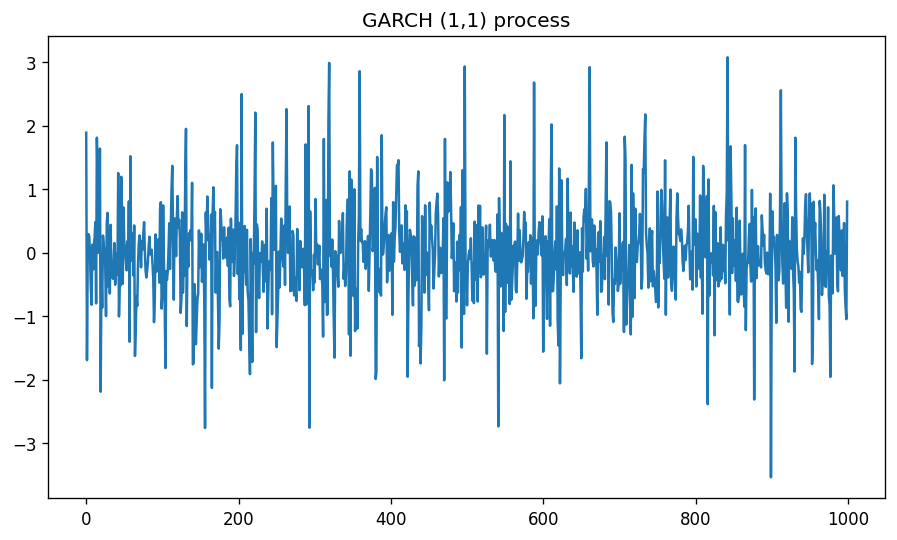

In [ ]:
import scipy as sp

n=1000 # n is the number of observations
n1=100 # we need to drop the first several observations
n2=n+n1 # sum of two numbers
alpha=(0.1,0.3) # GARCH (1,1) coefficients alpha0 and alpha1, see
a=(0.1,0.3) # ARCH (1) coefficients alpha0 and alpha1, see Equation

beta=0.2
errors=np.random.normal(0,1,n2)
t=np.zeros(n2)
t[0]=np.random.normal(0,np.sqrt(a[0]/(1-a[1])),1)
for i in range(1,n2-1):
    t[i]=errors[i]*np.sqrt(alpha[0]+alpha[1]*errors[i-1]**2+beta*t[i-1]**2)
y=t[n1-1:-1] # drop the first n1 observations
plt.title('GARCH (1,1) process')
x=range(n)
plt.plot(x,y)

In [ ]:
from arch import arch_model

am = arch_model(df['Balance'])
res = am.fit()

print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 894837980.6155534
Iteration:      2,   Func. Count:     12,   Neg. LLF: 114563.30053335318
Iteration:      3,   Func. Count:     18,   Neg. LLF: 291891.0918811089
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5336.992035289009
Iteration:      5,   Func. Count:     30,   Neg. LLF: 5642.670192838197
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4760.342078666608
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4804.00166571843
Iteration:      8,   Func. Count:     47,   Neg. LLF: 5670.510981919861
Iteration:      9,   Func. Count:     54,   Neg. LLF: 4745.970020244292
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4738.932962988565
Iteration:     11,   Func. Count:     64,   Neg. LLF: 4736.328296517595
Iteration:     12,   Func. Count:     69,   Neg. LLF: 4735.940085868222
Iteration:     13,   Func. Count:     74,   Neg. LLF: 4735.906245954549
Iteration:     14,   Func. Count:     79,   Neg. LLF: 4735.90601

Обычно коэффициент  GARCH модели   β1  близок к 0.9 для многих ежедневных финансовых данных.

Можно показать, что чем   α1+β1 ближе к 1, тем дольше мы ощущаем эффекты "шоков" в волатильности.

Если в модели a1 + b1 > 1, GARCH прогноз будет нестационарным и волатильность со временем возрастет до бесконечности.

In [ ]:
res.params

mu         -0.088044
omega       6.428910
alpha[1]    0.932878
beta[1]     0.067122
Name: params, dtype: float64

# Оценка модели на адекватность
Если GARCH оценена адекватно, то остатки не должны содержать автокорреляцию или любой другой тип нелинейной зависимости.

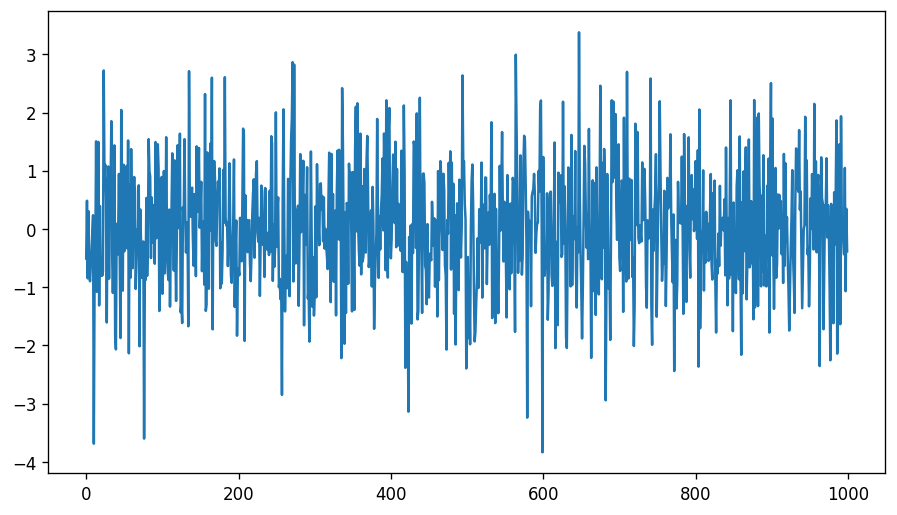

In [ ]:
normal = pd.Series(np.random.normal(0, 1, size=1000))
normal.plot();

Оценим параметры на 7 года, построим прогноз на 1 год вперед.

In [ ]:
df['Balance']

Date
2017-01-15   -15.589604
2017-01-16    12.286109
2017-01-17    -5.986892
2017-01-18     4.954974
2017-01-19    -8.664010
                ...    
2021-03-27    20.133646
2021-03-28   -30.542899
2021-03-29    39.857611
2021-03-30   -27.245827
2021-03-31     0.507560
Freq: D, Name: Balance, Length: 1537, dtype: float64

In [ ]:
split_date = pd.to_datetime('2021-03-01') 
am = arch_model(df['Balance'])
res = am.fit(last_obs=split_date, disp='off')

# res - результат фита модели на первых 7  годаъ

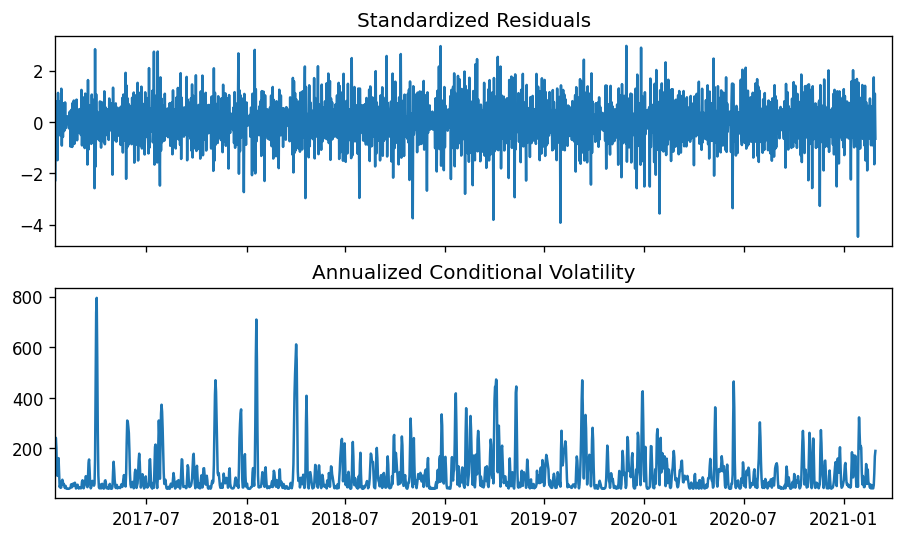

In [ ]:
fig = res.plot(annualize='D')

# остатки после фита модели:

После вызова forecast()  возвращается ARCHModelForecast объект с атрибутами:

mean - The forecast conditional mean.

variance - The forecast conditional variance.

residual_variance - The forecast conditional variance of residuals. 

In [ ]:
# строим прогноз на 30 горизонтов от даты split_date
forecasts = res.forecast(horizon=30, start=split_date) 
forecasts.variance.tail()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-27,415.194171,421.324474,427.454776,433.585079,439.715382,445.845685,451.975987,458.106290,464.236593,470.366896,...,537.800226,543.930529,550.060832,556.191134,562.321437,568.451740,574.582043,580.712345,586.842648,592.972951
2021-03-28,897.158946,903.289249,909.419552,915.549855,921.680157,927.810460,933.940763,940.071066,946.201369,952.331671,...,1019.765002,1025.895304,1032.025607,1038.155910,1044.286213,1050.416515,1056.546818,1062.677121,1068.807424,1074.937726
2021-03-29,1552.305647,1558.435950,1564.566252,1570.696555,1576.826858,1582.957161,1589.087463,1595.217766,1601.348069,1607.478372,...,1674.911702,1681.042005,1687.172308,1693.302610,1699.432913,1705.563216,1711.693519,1717.823821,1723.954124,1730.084427
2021-03-30,801.449638,807.579941,813.710244,819.840547,825.970850,832.101152,838.231455,844.361758,850.492061,856.622363,...,924.055694,930.185996,936.316299,942.446602,948.576905,954.707208,960.837510,966.967813,973.098116,979.228419
2021-03-31,63.371957,69.502260,75.632563,81.762866,87.893169,94.023471,100.153774,106.284077,112.414380,118.544682,...,185.978013,192.108315,198.238618,204.368921,210.499224,216.629527,222.759829,228.890132,235.020435,241.150738


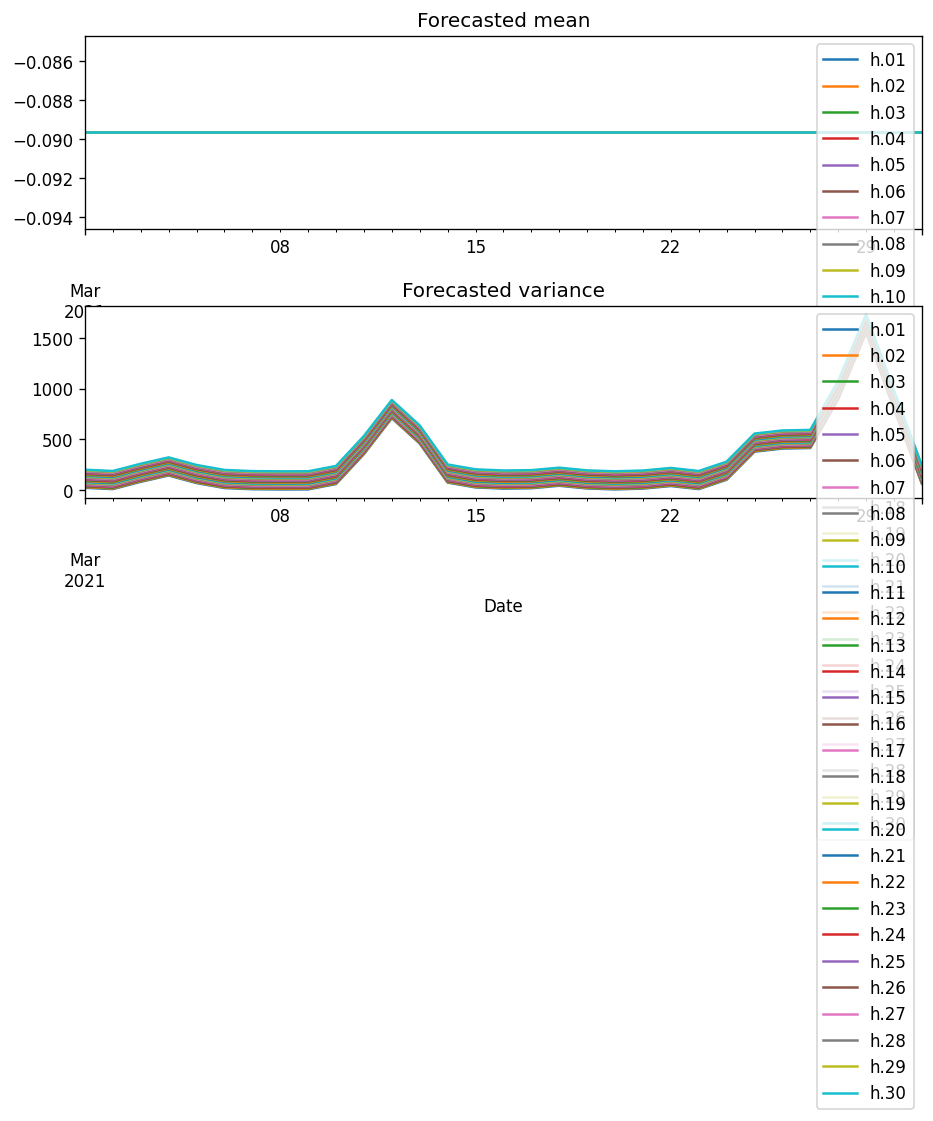

In [ ]:
# среднее прогноза 
forecasts.mean[split_date:].plot(ax=plt.subplot(2, 1, 1));
plt.title('Forecasted mean')

# дисперсия прогноза 
forecasts.variance[split_date:].plot(ax=plt.subplot(2, 1, 2));
plt.title('Forecasted variance')
plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

# Обоснование выбора метрики для оптимизации

Для выбора метрики важно понимать последствия ошибок. 
- Недооценка сальдо (прогноз ниже фактического). Отсутсвие возможности разместить больше средств на рынке деривативов. То есть потери прибыли в размере = value * (credit_rate + 0.5)/365.
- Переоценка сальдо (прогноз выше фактического). Допуск дефицит, что приведет к необходимости заимствования по высокой ставке (ключ + 1%), увеличивая затраты. То есть потери прибыли в размере = value * (credit_rate + 1)/365.

Ошибка по переоценке сальдо имеет большие потери, но оба варианта сильно зависят от разницы между прогнозом и фактическим значением

Рассмотрим несколько метрик и их применимость:

**MAE (Mean Absolute Error)**:
- Непосредственно измеряет среднюю абсолютную ошибку, что соответствует требованию заказчика (ошибка ≤ 0.42).
- Показывает среднее отклонение прогноза от фактического сальдо.
- Устойчива к знаку ошибки, что важно для сальдо, которое может быть положительным или отрицательным.
- Линейно штрафует ошибки, что отражает финансовые последствия, так как затраты/упущенная выгода пропорциональны величине ошибки.
- Не учитывает квадратичные эффекты, если крупные ошибки имеют непропорционально большие последствия.


**MSE (Mean Squared Error)**:
- Сильнее штрафует большие ошибки из-за квадратичной зависимости, что может быть полезно, если крупные отклонения критичны.
- Менее интерпретируема в контексте требования заказчика (0.42 в абсолютном значении).
- Чувствительна к выбросам, что может исказить оптимизацию, если в данных есть аномалии (например, в налоговые дни).

**RMSE (Root Mean Squared Error)**:
- Сохраняет интерпретируемость в единицах исходной переменной (как MAE).
- Учитывает большие ошибки сильнее, чем MAE.

**Custom Loss (асимметричная потеря)**:<br>
Можно разработать метрику, которая по-разному штрафует переоценку и недооценку сальдо, учитывая разницу в доходности/затратах (например, +0.5% для деривативов vs. +1% для заимствований).
- Точно отражает финансовые последствия.
- Сложнее реализовать и оптимизировать.

В датасете есть дни с нулевым сальдо (выходные), а также аномалии (налоговые дни). MAE менее чувствительна к выбросам, чем MSE или RMSE, что делает ее более стабильной для оптимизации, еще MAE легко объяснить бизнесу - средняя ошибка в единицах сальдо.

# Выбор модели

Так как GARCH модель может быть рассмотрена как  ARMA для квадратов отклонений, можно использовать информационный критерий  (AIC) или (BIC).

Если для ежедневных доходностей мы ограничемся только ARCH(p) модель, то мы можем подобрать очень большое значение p по информационному критерию. 

Для  GARCH(p,q) обычно подбираем p,q ≤ 2 по информационным критериям. Модель GARCH(p,q) с меньшим параметрами предпочтительна перед ARCH(p) с  большим параметром p (устойчивость оценок и переобучение).

# Приложение к финансам 

Рассмотрим индекс SP500:

Прогоним ARIMA(p, d, q) для наших данных и убедимся в автокорреляции остатков.

Выберем GARCH к ARIMA с наименьшим AIC.

Посмотрим на остатки модели

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

In [ ]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
      
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [ ]:

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl



In [ ]:
TS = df
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
res_tup = _get_best_model(TS)

aic:    inf | order: None


In [ ]:
order = res_tup[1]
model = res_tup[2]

tsplot(model.resid, lags=30)

In [ ]:
# Фит модели

p_ = order[0]
o_ = order[1]
q_ = order[2]


am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

In [ ]:
#Посмотрим на остатки

tsplot(res.resid, lags=30)

In [ ]:
# Выглядит, как белый шум. Посмотрим на квадраты

tsplot(res.resid**2, lags=30)


 # Анализ остатков

Анализ остатков — это техника, которая помогает понять, есть ли у прогнозирующей модели небольшие
недостатки, которые можно устранить доработкой, или же фундаментальные проблемы.

Остатки — это разность между фактом и прогнозом:
$$\hat ε_t = y_t − \hat y_t.$$

Их можно вычислять двумя способами. 

1. Прогнозы, которые участвуют в остатках, можно строить
с фиксированной отсрочкой. Например, начиная с момента R прогноз всегда делается на одну точку вперёд,
затем происходит переход в момент R + 1, получается новое истинное значение ряда, которое сравнивается с
прогнозом, затем следующий прогноз делается ещё на одну точку вперёд, и так далее до самого конца ряда:
$$\hat y_{R+d|R}, \dots , \hat y_{T|T −d}.$$


2. Остатки можно строить с фиксированным концом истории при разных отсрочках. Например,
берётся начальная часть ряда от 0 до T − D, и далее делаются прогнозы


$$ \hat y_{T −D+1|T −D},\dots , \hat y_{T|T −D},$$
полученные прогнозы сравниваются с истинными значениями ряда, и с их помощью вычисляются остатки.


В зависимости от задачи могут использоваться разные определения остатков, однако чаще используется
первое. Остатки оценивают ошибку, то есть шумовую компоненту, которую наблюдать невозможно. При
построении модели делаются предположения об этой шумовой компоненте, и логично, что свойства остатков
должны согласовываться с выдвинутыми предположениями.


# Несмещённость
Во-первых, остатки должны быть несмещёнными, то есть в среднем они должны быть равны нулю.

Гипотезу о несмещённости остатков $H_0 : ε = 0$ можно формально проверить с помощью какого-либо стандартного одновыборочного критерия (например, критерия Стьюдента или Уилкоксона). Если выясняется,
что остатки смещены, значит с моделью что-то не так. В этом случае рекомендуется провести визуальный
анализ, чтобы посмотреть, почему прогнозы систематически завышаются или занижаются.


На самом деле, модель очень легко скорректировать в случае, если остатки имеют смещение. Достаточно
вычислить среднее значение остатков, это и будет константой, на которую необходимо скорректировать все
прогнозы, чтобы остатки стали несмещёнными. После этого преобразования прогнозирующая модель улучшится.

# Стационарность

Ещё одно свойство, наличие которого предполагается у ошибок, — это стационарность, то есть отсутствие
зависимости от времени. Таким образом, остатки во времени должны быть распределены примерно одинаково.

Формально гипотезу о стационарности можно проверить с помощью критерия Дики-Фуллера. Если стационарность отсутствует, то модель неодинаково точна в разные периоды времени. Необходимо провести
визуальный анализ, чтобы понять, что с моделью не так, и почему прогнозы в разные периоды времени
систематически имеют разную ошибку.

 # Неавтокоррелированность


Ещё одно желаемое свойство остатков — это неавтокоррелированность, то есть отсутствие зависимости от
предыдущих наблюдений.


Гипотезу о неавтокоррелированности можно проверить по коррелограмме, а также с помощью Q-критерия Льюнга-Бокса (таблица 1.3). Этот критерий позволяет проверить гипотезу о равенстве нулю одновременно
нескольких автокорреляций при разных лагах (с лага 1 по лаг Q). Параметр Q можно выбирать, например,
перебором, а можно пользоваться значением по умолчанию, использующемся в функции, которая производит
оценку модели ARIMA.

ряд ошибок прогноза: $ε^T = ε_1, \dots, ε_T$
нулевая гипотеза: $H_0 : r_1 = · · · = r_Q = 0$
альтернатива: $H_1 : H_0 $ неверна
статистика: $Q(ε^T)= T (T + 2)\sum_{\tau=1}^Q \frac{r^2_τ}{T −τ}$
нулевое распределение: $Q(ε^T) ∼ χ^2_{Q−K}$ при $H_0$, 
K — число настраиваемых параметров модели.




Автокоррелированность остатков — признак того, что в данных присутствует информация, которая не
вошла в модель. 

Если в остатках есть структура, то можно попытаться её внести в модель явным образом.


Скорректированная модель будет лучше, а её остатки будут больше похожи на белый шум. 

Таким образом, автокоррелированность остатков только указывает на
потенциальную возможность улучшить модель, и не факт, что улучшения можно добиться на практике с
помощью рассматриваемого класса моделей.